In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import igraph as ig
import numpy as np
import seaborn as sns
import json

import collections
import xnetwork as xn
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [29]:
import sys
sys.path.append("../../src/")

In [30]:
from network.network_tools import sorting, infos
from utils.plots import *

# Load and prepare data

In [6]:
unarxiv_df = pd.read_csv('../../data/unarxiv/unarxiv_context_citations_labels.csv')
unarxiv_info = pd.read_csv('../../data/unarxiv/unarxiv_info.csv')

/tmp/ipykernel_3484/2590621313.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  unarxiv_df = pd.read_csv('../../data/unarxiv/unarxiv_context_citations_labels.csv')


In [7]:
unarxiv_df['qtd_tokens'] = unarxiv_df.text.apply(lambda x: len(x.split()))
unarxiv_df['cited_ids'] = unarxiv_df.cited_ids.apply(eval)
unarxiv_df['qtd_citations'] = unarxiv_df.cited_ids.apply(len)

In [8]:
# Fixing type and drop duplicates
unarxiv_df = unarxiv_df.explode('cited_ids')
unarxiv_df['cited_ids'] = unarxiv_df['cited_ids'].astype(str)
unarxiv_df['id'] = unarxiv_df['id'].astype(str)
unarxiv_df.drop_duplicates(inplace=True)

In [9]:
unarxiv_info = unarxiv_info.drop_duplicates(subset=['id'])
unarxiv_info = unarxiv_info.replace('nan', 'Unknown')

In [10]:
unarxiv_info['discipline'] = unarxiv_info['discipline'].astype(str)
unarxiv_info['id'] = unarxiv_info['id'].astype(str)

In [11]:
df = unarxiv_df.copy()

# Data classifications analysis 

In [17]:
df.head(3)

id discipline       section  \
0  1806.07088    Physics  Introduction   
0  1806.07088    Physics  Introduction   
1  1806.07088    Physics  Introduction   

                                                text   cited_ids       label  \
0  The [mathematical_formula]  pair production fr...   0708.1471  background   
0  The [mathematical_formula]  pair production fr...  1607.02055  background   
1  The available electric field strength for the ...   0808.2107  background   

   qtd_tokens  qtd_citations  
0         116              2  
0         116              2  
1         106              1

In [18]:
df.describe()

qtd_tokens  qtd_citations
count  303372.000000  303372.000000
mean      331.672293       4.296207
std      2713.584706       5.126387
min         1.000000       1.000000
25%        81.000000       1.000000
50%       126.000000       3.000000
75%       183.000000       5.000000
max     69419.000000      67.000000

/tmp/ipykernel_16947/472968078.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_counts.groupby('group')['freq'].sum().reindex(labels)


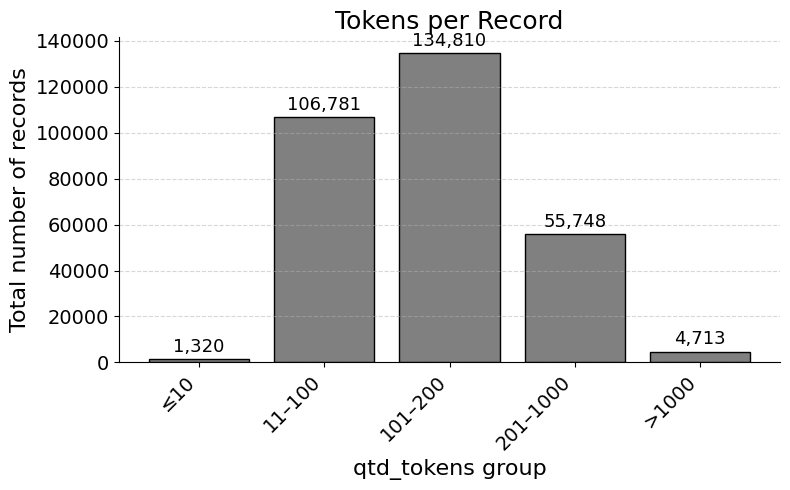

In [21]:
# === Example usage for qtd_tokens ===
# assume df is your DataFrame
token_bins  = [0, 10, 100, 200, 1000, df['qtd_tokens'].max()]
token_labels = ['≤10', '11–100', '101–200', '201–1000', '>1000']
plot_value_counts_by_group(
    df, 'qtd_tokens',
    bins=token_bins, labels=token_labels,
    title='Tokens per Record'
)

/tmp/ipykernel_16947/472968078.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_counts.groupby('group')['freq'].sum().reindex(labels)


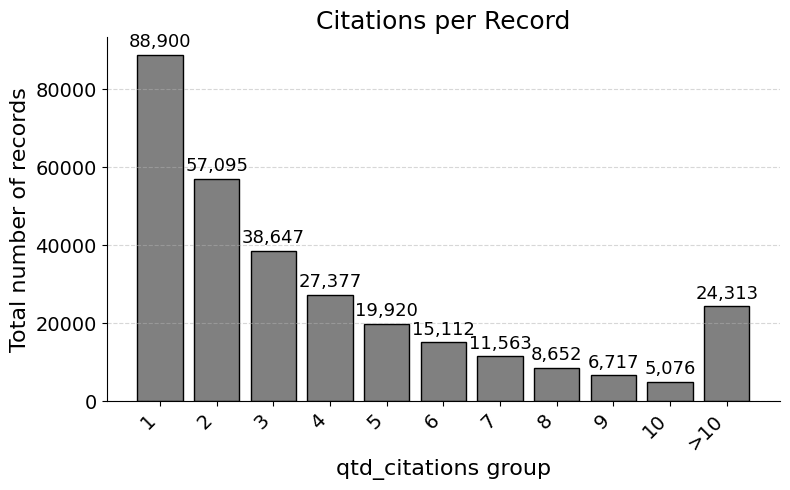

In [22]:
# === Example usage for qtd_citations ===
# create bins so 1–10 individually, >10 aggregated
max_cit = df['qtd_citations'].max()
cit_bins  = list(range(0, 11)) + [max_cit]
cit_labels = [str(i) for i in range(1, 11)] + ['>10']
plot_value_counts_by_group(
    df, 'qtd_citations',
    bins=cit_bins, labels=cit_labels,
    title='Citations per Record'
)

In [23]:
df_cited_papers = df.cited_ids.value_counts().reset_index()

In [24]:
df_cited_papers.head(20)

cited_ids  count
0   1512.03385   3006
1    1412.6980   1591
2   1911.05722    980
3   2103.14030    907
4   1505.04597    859
5   1506.01497    845
6   2003.08934    836
7   2005.12872    698
8   2104.14294    569
9   1812.04948    553
10  1703.10593    495
11  1612.03144    454
12  1912.04958    436
13  1604.01685    408
14  1801.07698    397
15  1611.07004    386
16  1612.00593    376
17   1411.4038    371
18  1710.09412    364
19  2011.10566    355

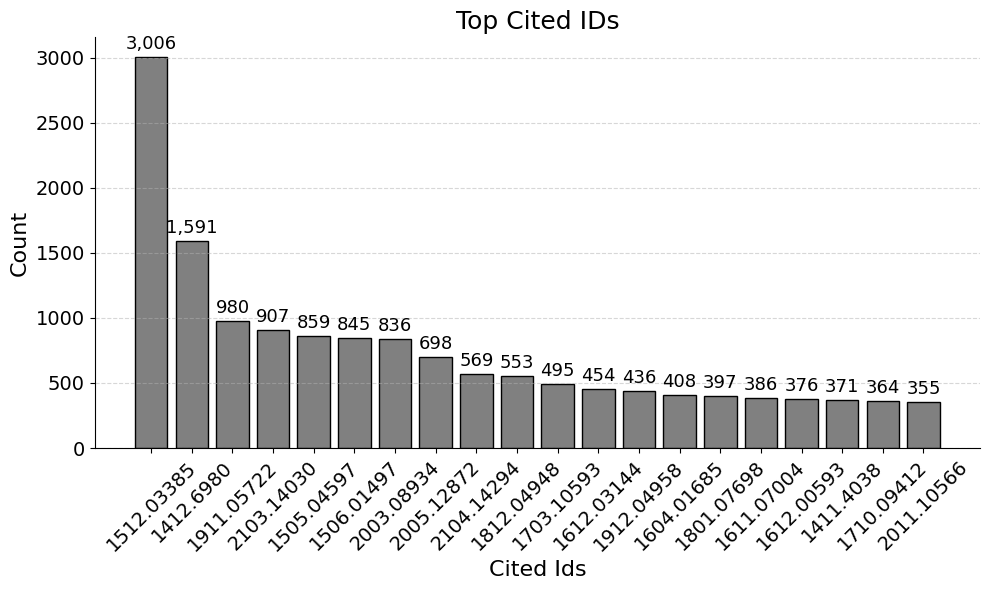

In [27]:
plot_top_cited_ids(df, column="cited_ids", top_n=20)

In [19]:
df[df.cited_ids == "1512.03385"].label.value_counts(normalize=True)

label
method        0.725882
background    0.265802
result        0.008317
Name: proportion, dtype: float64

In [38]:
df[(df.cited_ids == "1512.03385") & (df.label=="result")]

id        discipline  \
4049    2012.01506  Computer Science   
4990    2012.03196  Computer Science   
5558    2012.01274  Computer Science   
27330   2201.12712  Computer Science   
45840   2212.05611  Computer Science   
48114   2204.01536       Mathematics   
50592   2205.01586  Computer Science   
61333   2209.09211        Statistics   
61904   2207.05807  Computer Science   
62611   2203.07239  Computer Science   
63882   2207.01602        Statistics   
82930   2212.02773  Computer Science   
93022   2207.05501  Computer Science   
100839  2112.10652  Computer Science   
101705  2108.11941  Computer Science   
102640  2108.05732       Mathematics   
104860  2102.12122  Computer Science   
110008  2106.01401  Computer Science   
114920  2107.01372  Computer Science   
118501  2109.01486  Computer Science   
121122  2108.08205  Computer Science   
134199  2109.14196  Computer Science   
140251  2106.12011  Computer Science   
142237  2103.12718  Computer Science   
142238  2103.12718  Computer Science   

                                            section  \
4049                                   Introduction   
4990             Details of Keypoint Re-projection.   
5558     Transferability to different architectures   
27330                                  Introduction   
45840          Augmentation Resolution Relationship   
48114                                  Introduction   
50592                                 Related Works   
61333                     Global Landscape Analysis   
61904                       Water body segmentation   
62611                                  Introduction   
63882                                    Discussion   
82930                                  Introduction   
93022              Impact of Next Convolution Block   
100839                              Method Analysis   
101705      Detailed Results and More Architectures   
102640                           Main contributions   
104860                         Image Classification   
110008    Detection and Segmentation with Mask-RCNN   
114920                      Quantitative evaluation   
118501                                  MRI Dataset   
121122               CIFAR-100 image classification   
134199  Advantages of Feature-level Style Injection   
140251                    Visual Saliency Detection   
142237               HPT with Supervised Base Model   
142238               HPT with Supervised Base Model   

                                                     text   cited_ids   label  \
4049    The resulting reconstructions are discriminati...  1512.03385  result   
4990    Compared to frame-wisely applying CMR [1] (Tab...  1512.03385  result   
5558    Here we present the results of transferability...  1512.03385  result   
27330   In summary, our contributions can be highlight...  1512.03385  result   
45840   In order to examine the relationship between r...  1512.03385  result   
48114   Our work also differs from previous efforts in...  1512.03385  result   
50592   Only recently few works considered self-attent...  1512.03385  result   
61333   [leftmargin=*]\nEfficient global optimization ...  1512.03385  result   
61904   DeepLabV3+ [16] extends the former DeeplabV3 [...  1512.03385  result   
62611   As a first contribution of our work, we show t...  1512.03385  result   
63882   However, there are many limitations of this wo...  1512.03385  result   
82930   To this end, we evaluate DiffusionInst on COCO...  1512.03385  result   
93022   As shown in Table REF , NCB achieves the best ...  1512.03385  result   
100839  Secondly, skip connections are used extensivel...  1512.03385  result   
101705  Table REF  and Table REF  expand the average v...  1512.03385  result   
102640  The wavefront set returned by the microlocal l...  1512.03385  result   
104860  Results.\nIn Table REF , we see that our PVT m...  1512.03385  result   
110008  Table REF  also compares several backbones for...  1512.03385  result   
11492

In [20]:
df[df.cited_ids == "1412.6980"].label.value_counts(normalize=True)

label
method        0.941546
background    0.058454
Name: proportion, dtype: float64

In [81]:
df[df.cited_ids == "1911.05722"].label.value_counts(normalize=True)

label
background    0.524490
method        0.457143
result        0.018367
Name: proportion, dtype: float64

In [28]:
result_df_results = df[(df.cited_ids == "1512.03385") & (df.label == "result")]

In [29]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [30]:
result_df_results.shape

(25, 8)

In [31]:
result_df_results[['text', 'label']]

text  \
4049                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### LLM analysis

Text ID | Provided Label | Correct? | Justification
4049 | result | ✅ Correct | The excerpt reports experimental superiority of FRN over prior reconstruction-based approaches—i.e. it directly compares its findings to others’ results (fits Result comparison).
4990 | result | ✅ Correct | It contrasts PCK scores of test-time tuned vs. baseline models, verifying effectiveness by comparison (again a Result comparison).
5558 | result | ✅ Correct | Describes how poisoned data transfer to larger models reduces certified radius “even if the victim uses a larger model” – a direct comparison of results across settings.
27330 | result | ✅ Correct | Summarizes that “experimental results demonstrate … outperforms other recent MBPs” – clearly comparing own results to others’.
45840 | result | ✅ Correct | Reports how varying resolution/augmentation confirms previous findings and motivates new method—presents comparisons of results.
48114 | result | ❌ Incorrect (should be Background information) | Discusses how the work “differs from previous efforts” in architecture choice, summarizing prior work rather than comparing experimental findings.
50592 | result | ❌ Incorrect (should be Background information) | Reviews recent literature on self-attention in continual learning and their conclusions—this is context-setting, not comparison of new results.
61333 | result | ❌ Incorrect (should be Method) | Lays out a theorem and its implications for optimization methods; this is a methodological/theoretical contribution, not a result comparison.
61904 | result | ✅ Correct | Compares DeepLabV3+ performance, quantifying IoU improvements vs. other methods—fits Result comparison.
62611 | result | ✅ Correct | Shows Conformer vs. ResNet backbones, reporting better WSSS performance—another clear result comparison.
63882 | result | ❌ Incorrect (should be Background information) | Enumerates limitations and future directions—this is critique/context, not a comparison of results.
82930 | result | ✅ Correct | Reports AP on COCO vs. Mask RCNN, SOLO, CondInst, etc.—direct performance comparison.
93022 | result | ✅ Correct | Shows that NCB “outperforms” ConvNeXt block by specific metrics—a result comparison.
100839 | result | ❌ Incorrect (should be Method) | Describes the use and advantage of skip connections in the architecture—this is a methodological detail, not results comparison.
101705 | result | ✅ Correct | Compares average values on two architectures (ResNet-18 vs. WideResNet-28) and observes trends—within-paper result comparison.
102640 | result | ❌ Incorrect (should be Method) | Explains how the wavefront set is computed and tested across data domains—this is part of the method setup, not comparing outcomes.

# Network Analysis

In [24]:
# Remove Intents
G_full = nx.from_pandas_edgelist(df, source="id", target="cited_ids", create_using=nx.DiGraph())
df_background = df[df.label != 'background']
G_filtered_background = nx.from_pandas_edgelist(df_background, source="id", target="cited_ids", create_using=nx.DiGraph())

df_result = df[df.label != 'result']
G_filtered_result = nx.from_pandas_edgelist(df_result, source="id", target="cited_ids", create_using=nx.DiGraph())

df_method = df[df.label != 'method']
G_filtered_method = nx.from_pandas_edgelist(df_method, source="id", target="cited_ids", create_using=nx.DiGraph())

In [47]:
# Keep intents
G_full = nx.from_pandas_edgelist(df, source="id", target="cited_ids", create_using=nx.DiGraph())
df_background = df[df.label == 'background']
G_filtered_background = nx.from_pandas_edgelist(df_background, source="id", target="cited_ids", create_using=nx.DiGraph())

df_result = df[df.label == 'result']
G_filtered_result = nx.from_pandas_edgelist(df_result, source="id", target="cited_ids", create_using=nx.DiGraph())

df_method = df[df.label == 'method']
G_filtered_method = nx.from_pandas_edgelist(df_method, source="id", target="cited_ids", create_using=nx.DiGraph())

In [14]:
metrics = {}
for name, G in [
    ("Full Network", G_full),
    ("Background Filtered", G_filtered_background),
    ("Result Filtered", G_filtered_result),
    ("Method Filtered", G_filtered_method),
]:
    metrics[name] = {
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges(),
        "Components": nx.number_weakly_connected_components(G)
    }

# --- build the summary DataFrame ---
summary = pd.DataFrame({
    "Metric": ["Nodes", "Edges", "Components"],
    "Full Network": [
        metrics["Full Network"]["Nodes"],
        metrics["Full Network"]["Edges"],
        metrics["Full Network"]["Components"],
    ],
    "Background Filtered": [
        metrics["Background Filtered"]["Nodes"],
        metrics["Background Filtered"]["Edges"],
        metrics["Background Filtered"]["Components"],
    ],
    "Result Filtered": [
        metrics["Result Filtered"]["Nodes"],
        metrics["Result Filtered"]["Edges"],
        metrics["Result Filtered"]["Components"],
    ],
    "Method Filtered": [
        metrics["Method Filtered"]["Nodes"],
        metrics["Method Filtered"]["Edges"],
        metrics["Method Filtered"]["Components"],
    ],
})

# --- compute differences relative to full network ---
for col in ["Background Filtered", "Result Filtered", "Method Filtered"]:
    diff_col = f"Abs Diff ({col})"
    pct_col  = f"% Diff ({col})"
    summary[diff_col] = summary["Full Network"] - summary[col]
    summary[pct_col]  = summary[diff_col] / summary["Full Network"] * 100

print(summary)

       Metric  Full Network  Background Filtered  Result Filtered  \
0       Nodes         76640                37644            76115   
1       Edges        171403                65739           170070   
2  Components           340                 2267              347   

   Method Filtered  Abs Diff (Background Filtered)  \
0            70877                           38996   
1           137850                          105664   
2              511                           -1927   

   % Diff (Background Filtered)  Abs Diff (Result Filtered)  \
0                     50.882046                         525   
1                     61.646529                        1333   
2                   -566.764706                          -7   

   % Diff (Result Filtered)  Abs Diff (Method Filtered)  \
0                  0.685021                        5763   
1                  0.777699                       33553   
2                 -2.058824                        -171   

   % Diff (Metho

In [17]:
def compute_centralities(G):
    return {
        # "degree_in":     nx.in_degree_centrality(G),
        # "degree_out":    nx.out_degree_centrality(G),
        # "pagerank":      nx.pagerank(G),
        # "betweenness":   nx.betweenness_centrality(G),
        "closeness":     nx.closeness_centrality(G),
        # "eigenvector":   nx.eigenvector_centrality_numpy(G, max_iter=500)
    }

graphs = {
    "Full Network":          G_full,
    "Background Filtered":   G_filtered_background,
    "Result Filtered":       G_filtered_result,
    "Method Filtered":       G_filtered_method,
}

# graphs = {
#     "Full Network":          G_full,
#     "Just Background":   G_filtered_background,
#     "Just Result":       G_filtered_result,
#     "Just Method":       G_filtered_method,
# }

centralities = {
    name: compute_centralities(G)
    for name, G in graphs.items()
}

In [18]:
centralities.keys()

dict_keys(['Full Network', 'Background Filtered', 'Result Filtered', 'Method Filtered'])

In [17]:
# centralities["Full Network"]

### Save or Load json with centralities

In [17]:
# with open("centralities_results/centralities_just_intent.json", "w", encoding="utf-8") as fp:
#     json.dump(centralities, fp, indent=2, ensure_ascii=False)

In [4]:
with open("../../data/unarxiv/centralities_results/centralities.json", "r", encoding="utf-8") as fp:
    centralities = json.load(fp)
# with open("centralities_results/centralities_just_intent.json", "r", encoding="utf-8") as fp:
#     centralities = json.load(fp)

In [5]:
centralities.keys()

dict_keys(['Full Network', 'Background Filtered', 'Result Filtered', 'Method Filtered'])

In [85]:
centralities.get("Full Network").keys()

dict_keys(['degree_in', 'degree_out', 'pagerank', 'betweenness', 'closeness', 'eigenvector'])

In [14]:
# centralities = {
#   'Full Network': {'closeness': {...}, 'pagerank': {...}, ...},
#   'Background Filtered': {'closeness': {...}, ...},
#   'Method Filtered': {...},
#   'Result Filtered': {...},
# }

results = evaluate_all(
    data=centralities,
    baseline_key="Full Network",
    scenarios=["Background Filtered", "Method Filtered", "Result Filtered"],
    measures=["degree_in", "degree_out", "pagerank", "betweenness", "closeness", "eigenvector"],
    topk_list=[10, 50, 100, 500],
    pct_list=[0.01, 0.05],
    thresholds=[10, 50, 100, 500],
)

# DataFrames resultantes:
correlations_df = results["correlations_df"]  # Spearman, Kendall, n_common
deltas_df       = results["deltas_df"]       # Estatísticas de Δr
jaccard_df      = results["jaccard_df"]      # J@10, J@50, J@100, J@500 (ajustado ao n)
churn_df        = results["churn_df"]        # churn em top-1% e top-5%


In [15]:
correlations_df.head()

scenario      measure  n_common  spearman  kendall_tau  \
0  Background Filtered  betweenness     37644  0.688864     0.673866   
1  Background Filtered    closeness     37644  0.809752     0.720333   
2  Background Filtered    degree_in     37644  0.807051     0.750435   
3  Background Filtered   degree_out     37644  0.973113     0.896667   
4  Background Filtered  eigenvector     37644  0.008756     0.005958   

   kendall_p  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4   0.082923

In [23]:
jaccard_df.to_dict(orient="records")

[{'scenario': 'Background Filtered',
  'measure': 'betweenness',
  'J@10': 0.17647058823529413,
  'J@50': 0.35135135135135137,
  'J@100': 0.4084507042253521,
  'J@500': 0.42653352353780316},
 {'scenario': 'Background Filtered',
  'measure': 'closeness',
  'J@10': 0.6666666666666666,
  'J@50': 0.6129032258064516,
  'J@100': 0.6129032258064516,
  'J@500': 0.4836795252225519},
 {'scenario': 'Background Filtered',
  'measure': 'degree_in',
  'J@10': 0.6666666666666666,
  'J@50': 0.6666666666666666,
  'J@100': 0.6949152542372882,
  'J@500': 0.6366612111292962},
 {'scenario': 'Background Filtered',
  'measure': 'degree_out',
  'J@10': 0.25,
  'J@50': 0.2345679012345679,
  'J@100': 0.2345679012345679,
  'J@500': 0.22549019607843138},
 {'scenario': 'Background Filtered',
  'measure': 'eigenvector',
  'J@10': 0.0,
  'J@50': 0.041666666666666664,
  'J@100': 0.08108108108108109,
  'J@500': 0.12612612612612611},
 {'scenario': 'Background Filtered',
  'measure': 'pagerank',
  'J@10': 0.538461538461

In [25]:
churn_df.to_dict(orient="records")

[{'scenario': 'Background Filtered',
  'measure': 'betweenness',
  'pct': 0.01,
  'k': 376,
  'enter': 0.4015957446808511,
  'leave': 0.4015957446808511,
  'stable': 0.598404255319149},
 {'scenario': 'Background Filtered',
  'measure': 'betweenness',
  'pct': 0.05,
  'k': 1882,
  'enter': 0.4165781083953241,
  'leave': 0.4165781083953241,
  'stable': 0.5834218916046758},
 {'scenario': 'Background Filtered',
  'measure': 'closeness',
  'pct': 0.01,
  'k': 376,
  'enter': 0.3723404255319149,
  'leave': 0.3723404255319149,
  'stable': 0.6276595744680851},
 {'scenario': 'Background Filtered',
  'measure': 'closeness',
  'pct': 0.05,
  'k': 1882,
  'enter': 0.30393198724760895,
  'leave': 0.30393198724760895,
  'stable': 0.696068012752391},
 {'scenario': 'Background Filtered',
  'measure': 'degree_in',
  'pct': 0.01,
  'k': 376,
  'enter': 0.2154255319148936,
  'leave': 0.2154255319148936,
  'stable': 0.7845744680851063},
 {'scenario': 'Background Filtered',
  'measure': 'degree_in',
  'pct

In [21]:
deltas_df.to_dict(orient="records")

[{'scenario': 'Background Filtered',
  'measure': 'betweenness',
  'n': 37644,
  'delta_mean': -17275.290046222504,
  'delta_median': -20844.5,
  'delta_std': 10060.883508680434,
  'p10': -20844.5,
  'p90': -1274.5,
  'p95': 15746.0,
  'max_drop': 19982.5,
  'max_gain': -39246.5,
  'frac_|Δr|>10': 0.9989905429816173,
  'frac_|Δr|>50': 0.9960418659016045,
  'frac_|Δr|>100': 0.9929338008713208,
  'frac_|Δr|>500': 0.9784029327382849},
 {'scenario': 'Background Filtered',
  'measure': 'closeness',
  'n': 37644,
  'delta_mean': -17724.273987886514,
  'delta_median': -16989.0,
  'delta_std': 17707.659873563793,
  'p10': -39586.0,
  'p90': 4452.0,
  'p95': 9574.5,
  'max_drop': 33024.0,
  'max_gain': -39586.0,
  'frac_|Δr|>10': 0.998326426522155,
  'frac_|Δr|>50': 0.9935979173307832,
  'frac_|Δr|>100': 0.9895600892572521,
  'frac_|Δr|>500': 0.9571777706938689},
 {'scenario': 'Background Filtered',
  'measure': 'degree_in',
  'n': 37644,
  'delta_mean': -16985.294788014027,
  'delta_median': -

In [27]:
# for metric in centralities["Full Network"]:
#     df_metric = pd.DataFrame({
#         name: cent_dict[metric]
#         for name, cent_dict in centralities.items()
#     })
#     df_metric.index.name = "node"
#     print(f"\n=== {metric.upper()} comparison ===")
#     print(df_metric.head())

In [28]:
def top_k_stability(full_dict, filtered_dict, k_fraction=0.10):
    k_full     = int(len(full_dict) * k_fraction)
    k_filtered = int(len(filtered_dict) * k_fraction)
    
    top_full     = set(sorted(full_dict,     key=full_dict.get,     reverse=True)[:k_full])
    top_filtered = set(sorted(filtered_dict, key=filtered_dict.get, reverse=True)[:k_filtered])

    # Jaccard similarity of the two top-k sets
    return len(top_full & top_filtered) / len(top_full | top_filtered)

# --- assemble stability rows ---
rows = []
for measure in centralities["Full Network"]:
    full_c = centralities["Full Network"][measure]
    for filt_name in ["Background Filtered", "Result Filtered", "Method Filtered"]:
        filt_c = centralities[filt_name][measure]
        stab   = top_k_stability(full_c, filt_c, k_fraction=0.10)
        rows.append({
            "Centrality Measure": measure,
            "Filtered Network":   filt_name,
            "Top 10% Stability":  stab
        })

# --- pivot into a clean comparison table ---
stability_df = (
    pd.DataFrame(rows)
      .pivot(index="Centrality Measure", columns="Filtered Network", values="Top 10% Stability")
      .reset_index()
)

print(stability_df.round(4))


Filtered Network Centrality Measure  Background Filtered  Method Filtered  \
0                       betweenness               0.4074           0.8632   
1                         closeness               0.4228           0.7676   
2                         degree_in               0.4207           0.7787   
3                        degree_out               0.4554           0.8122   
4                       eigenvector               0.0803           0.0800   
5                          pagerank               0.2862           0.6816   

Filtered Network  Result Filtered  
0                          0.9897  
1                          0.9830  
2                          0.9887  
3                          0.9895  
4                          0.1354  
5                          0.9669  


In [53]:
df_plot.sort_values(by="rank_filtered", ascending=True)

paper  eigenvector_full  eigenvector_filtered  rank_full  \
5475   1908.07966      1.702710e-15              0.418297        164   
5531   1708.04198      9.023862e-16              0.244007        168   
5477   2007.02210      1.069894e-15              0.244007        166   
5476   2004.03717      1.064741e-15              0.220768        167   
11625  1703.00626      8.373084e-16              0.209149        177   
...           ...               ...                   ...        ...   
26246  2009.10273      1.235763e-01             -0.041578         12   
3268   1902.06162      1.491697e-01             -0.041578          1   
575    1604.07379      1.129751e-01             -0.041578         16   
2753   1603.09246      1.129751e-01             -0.046528         15   
3271   1911.05722      1.491697e-01             -0.072266          2   

       rank_filtered  
5475               1  
5531               2  
5477               3  
5476               4  
11625              5  
...              ...  
26246          76636  
3268           76637  
575            76638  
2753           76639  
3271           76640  

[76640 rows x 5 columns]

In [21]:
import os
# Caminho da pasta onde os PDFs serão salvos
output_dir = "centrality_plots_log"
os.makedirs(output_dir, exist_ok=True)

In [22]:
pd.set_option("display.precision", 8)

In [25]:
df = plot_rank_histograms_by_intent(
    centralities,
    output_dir=output_dir,
    # top_k=1000,
    intents=None,
    # log_color=True,
    log_axes=False,
    bins=20,
    cmap="inferno",
    invert=False,   # set True if you want rank 1 at top-right
    text_width=None,           # int or None. If set, wrap/truncate to this many chars
    text_mode="wrap",          # "wrap" or "truncate"
    title_fs=14,               # title (panel + suptitle) font size
    label_fs=12,               # axis & colorbar label font size
    tick_fs=12,  
    # rank_tick_step=100,
)

In [134]:
full_qty = len(list(centralities.get("Full Network").get("closeness").keys()))

In [131]:
centralities.get("Full Network").keys()

dict_keys(['degree_in', 'degree_out', 'pagerank', 'betweenness', 'closeness', 'eigenvector'])

In [128]:
background_qty = len(list(centralities.get("Background Filtered").get("closeness").keys()))

In [132]:
result_qty = len(list(centralities.get("Result Filtered").get("closeness").keys()))

In [133]:
method_qty = len(list(centralities.get("Method Filtered").get("closeness").keys()))

In [147]:
print(full_qty, background_qty, result_qty, method_qty)
print(full_qty,  (full_qty - background_qty)/full_qty, (full_qty - result_qty)/full_qty, (full_qty - method_qty) / full_qty)

76640 37644 76115 70877
76640 0.5088204592901879 0.006850208768267223 0.07519572025052192


In [77]:
df.sort_values(by=["rank_full"]).head(50)

paper        full  rank_full  filtered_Background  \
79     1512.03385  0.02348674          1           0.03963552   
80      1412.6980  0.01714532          2           0.03437558   
40     1505.04597  0.00713736          3           0.01086523   
314    1506.01497  0.00608046          4           0.00807587   
3271   1911.05722  0.00537585          5           0.00632256   
16638  2103.14030  0.00441029          6           0.00563186   
2711   2005.12872  0.00425371          7           0.00456924   
1208   1612.03144  0.00374483          8           0.00587095   
155     1411.4038  0.00348387          9           0.00313471   
42     1703.10593  0.00317071         10           0.00377228   
3856   1801.03924  0.00310547         11           0.00549903   
3284   1812.04948  0.00307937         12           0.00401137   
65     1611.07004  0.00289670         13           0.00369259   
1825   1608.06993  0.00280536         14           0.00358632   
3958   2003.08934  0.00277926         15           0.00403794   
1273   1709.01507  0.00271402         16           0.00377228   
160    1604.01685  0.00262269         17           0.00456924   
479    1606.00915  0.00253135         18           0.00324097   
828    1612.00593  0.00253135         19           0.00363945   
3891   1710.09412  0.00253135         20           0.00414420   
10338  2104.14294  0.00253135         21           0.00353319   
1637   1801.07698  0.00241391         22           0.00403794   
780    1506.02640  0.00227038         23           0.00188614   
3956   1912.04958  0.00219210         24           0.00300189   
66     1603.08155  0.00206161         25           0.00294876   
315    1512.02325  0.00204857         26           0.00207210   
3281   2011.10566  0.00202247         27           0.00217836   
963    1503.03832  0.00198332         28           0.00278936   
5167   1711.07971  0.00195723         29           0.00164705   
2715   1610.02391  0.00189199         30           0.00244401   
2754   1803.07728  0.00189199         31           0.00130170   
2805   1907.11692  0.00187894         32           0.00228462   
911    1512.00567  0.00183979         33           0.00302845   
2870   1802.02611  0.00183979         34           0.00270967   
1534   1612.01105  0.00174846         35           0.00225806   
2887   1705.07750  0.00173541         36           0.00281593   
2753   1603.09246  0.00172236         37           0.00100948   
16640  2102.12122  0.00170931         38           0.00172675   
63      1411.7766  0.00159188         39           0.00289562   
575    1604.07379  0.00159188         40           0.00098292   
730     1311.2524  0.00155273         41           0.00116888   
1649   1801.04381  0.00153969         42           0.00239088   
8663   1901.05103  0.00151359         43           0.00132827   
398    1505.05192  0.00146140         44           0.00066413   
3813   1810.03961  0.00144835         45           0.00122201   
4623   1905.04899  0.00144835         46           0.00231119   
3006   1611.05431  0.00140920         47           0.00220493   
580    1505.07818  0.00135701         48           0.00154079   
1298   1603.08511  0.00135701         49           0.00100948   
17167  2106.08254  0.00135701         50           0.00183301   

       rank_filtered_Background  filtered_Method  rank_filtered_Method  \
79                            1       0.00922738                     1   
80                            2       0.00100175                    46   
40                            3       0.00351318                     6   
314                           4       0.00402111                     3   
3271                          5       0.00461369                     2   
16638                         7       0.00365427                     4   
2711                         10       0.00352729                     5   
1208                          6       0.00153790                    22   
155                          2

In [18]:
## Analysis filaments
import pandas as pd
import numpy as np

vals = list(centralities["Background Filtered"]["closeness"].values())

# How many unique values?
n_unique = len(set(vals))
n_total = len(vals)
print("Total papers:", n_total)
print("Unique closeness values:", n_unique)
print("Duplicates:", n_total - n_unique)


df = pd.DataFrame({
    "paper": list(centralities["Background Filtered"]["closeness"].keys()),
    "closeness": vals
})

# Count group sizes
groups = df.groupby("closeness").size().sort_values(ascending=False)

print(groups.head(20))


Total papers: 37644
Unique closeness values: 697
Duplicates: 36947
closeness
0.00002657    16183
0.00000000     8920
0.00005313     3207
0.00003542     2561
0.00007970      990
0.00005977      775
0.00004782      440
0.00010626      416
0.00008501      327
0.00007084      223
0.00013283      213
0.00006072      173
0.00011069      169
0.00013662      108
0.00008302      108
0.00009488      106
0.00011954      104
0.00007379       86
0.00010626       80
0.00015939       80
dtype: int64


In [21]:
rank_full_dict, rank_filtered_dict = build_rank_dictionaries_safe(centralities)

In [22]:
df = pd.DataFrame({
    "paper": list(rank_full_dict.keys()),
    "rank_full": [rank_full_dict.get(p) for p in rank_full_dict.keys()],
    "rank_filtered_bg": [rank_filtered_dict["Background"].get(p) for p in rank_full_dict.keys()],
})

# Identify closeness plateaus in Background-filtered network
vals = list(centralities["Background Filtered"]["closeness"].values())

df_cl = pd.DataFrame({
    "paper": list(centralities["Background Filtered"]["closeness"].keys()),
    "closeness": vals
})

plateaus = df_cl.groupby("closeness").size().sort_values(ascending=False)

print(plateaus.head(5))


closeness
0.00002657    16183
0.00000000     8920
0.00005313     3207
0.00003542     2561
0.00007970      990
dtype: int64


In [24]:
plateaus_bg = find_closeness_plateaus(centralities,
                                      filt_key="Background Filtered",
                                      measure="closeness",
                                      min_size=50)
print(f"{len(plateaus_bg)} plateaus with ≥50 papers.")
print("Largest plateau size:", len(plateaus_bg[0][1]))


25 plateaus with ≥50 papers.
Largest plateau size: 16183


In [26]:
# Suppose G_bg is your background-filtered graph
# and you want to analyze the largest plateau:

val, plateau_nodes = plateaus_bg[0]
print("Closeness value:", val, "size:", len(plateau_nodes))

stats_bg = analyze_plateau_module(G_filtered_background.to_undirected(), plateau_nodes, n_random=20)
for k, v in stats_bg.items():
    print(f"{k}: {v}")


Closeness value: 2.6565364078314694e-05 size: 16183
k: 16183
density_plateau: 6.109824725701519e-08
density_random_mean: 9.458046861790488e-05
density_random_std: 3.8331454859011595e-06
avg_deg_plateau: 0.0009886918371130198
avg_deg_random_mean: 1.5305011431749365
avg_deg_random_std: 0.062027960252852565
n_components_plateau: 16179


## Wrost and Best ranks

In [12]:
rank_full_dict, rank_filtered_dict = build_rank_dictionaries_safe(centralities)

In [14]:
def find_method_movers(rank_full, rank_method, quantile=0.99, mode="worst"):
    """
    Compare ranks with and without Method sentences.

    Parameters
    ----------
    rank_full : dict
        {paper_id: rank} using the full text.
    rank_method : dict
        {paper_id: rank} after removing Method sentences.
    quantile : float
        Tail size. For mode="worst"/"best", uses the corresponding tail.
        Example: 0.99 => top 1% worst, bottom 1% best.
    mode : {"worst","best","both","abs"}
        - "worst": largest positive jumps (rank got worse; rm - rf is big +)
        - "best" : most negative jumps (rank got better; rm - rf is big -)
        - "both" : union of worst and best tails
        - "abs"  : largest absolute changes |jump|

    Returns
    -------
    df_all : pd.DataFrame
        All papers with rank_full, rank_method, jump.
    df_selected : pd.DataFrame
        Selected movers based on mode/quantile.
    """
    rows = []
    for p, rm in rank_method.items():
        if p in rank_full:
            rf = rank_full[p]
            jump = rm - rf  # + means worse, - means better
            rows.append((p, rf, rm, jump))

    df = pd.DataFrame(rows, columns=["paper", "rank_full", "rank_method", "jump"])

    if df.empty:
        return df, df.copy()

    if mode == "worst":
        thresh = df["jump"].quantile(quantile)
        df_sel = df[df["jump"] >= thresh].sort_values("jump", ascending=False)

    elif mode == "best":
        # bottom tail (e.g., 0.01 when quantile=0.99)
        thresh = df["jump"].quantile(1 - quantile)
        df_sel = df[df["jump"] <= thresh].sort_values("jump", ascending=True)

    elif mode == "abs":
        df2 = df.assign(abs_jump=df["jump"].abs())
        thresh = df2["abs_jump"].quantile(quantile)
        df_sel = df2[df2["abs_jump"] >= thresh].sort_values("abs_jump", ascending=False)

    elif mode == "both":
        hi = df["jump"].quantile(quantile)
        lo = df["jump"].quantile(1 - quantile)
        df_sel = df[(df["jump"] >= hi) | (df["jump"] <= lo)].sort_values("jump", ascending=False)

    else:
        raise ValueError("mode must be one of: 'worst', 'best', 'both', 'abs'")

    return df, df_sel

In [22]:
df_all, df_filtered= find_method_movers(
    rank_full_dict,
    rank_filtered_dict["Background"],
    quantile=0.99,   # top 1% worst jumps
    mode="worst"
)

print(df_filtered.paper.values[:70])
df_filtered.shape

['2012.10029' '1209.6594' '2106.02233' '2009.09716' '2008.00714'
 '2106.06742' '2012.14291' '2003.05511' '2007.03196' '1711.01151'
 '2012.13656' '2101.01921' '2102.10244' '1802.07669' '2106.04975'
 '2010.15764' '2101.10695' '2102.03781' '1907.12839' '1408.2335'
 '1710.03416' '2110.12181' '2005.08128' '1705.08922' '1906.07547'
 '2008.05031' '1608.00591' 'hep-th/0405152' 'quant-ph/9508027' '1406.1516'
 '2101.03628' '1704.07065' '1907.01686' '2104.00114' '1301.2016'
 '0705.0246' '2102.07111' '2111.06898' '1812.00329' 'quant-ph/0703255'
 '2008.03546' '2112.01264' 'hep-ph/9407247' '1808.03585' '2106.12287'
 '2202.11457' '2107.11878' '2104.09771' '2101.02374' '1910.07954'
 '2012.05312' '1812.05667' '2105.03125' '1408.5099' '2207.00254'
 '2111.10944' '2003.03105' '1811.08967' '1811.11709' '1702.07841'
 '2012.14695' '1908.01174' '2106.13814' '1510.05267' '2105.01114'
 '1303.2300' '1707.05653' '2103.11571' '1812.00535' '2007.06115']


(377, 4)

In [23]:
print(df_filtered.head())

            paper  rank_full  rank_method   jump
37599  2012.10029       4351        37637  33286
27761   1209.6594       3267        35363  32096
30035  2106.02233       4555        35879  31324
32645  2009.09716       5338        36511  31173
10415  2008.00714        160        31188  31028


Top 5 papers that increase ranking after filtering background intent.

                 paper  rank_full  rank_method   jump
 381  quant-ph/9811063      68891        12725 -56166  
 70          1203.5056      68527        12578 -55949
 609        1708.09545      68187        12831 -55356
 541        1905.12888      68098        12800 -55298
 157        1802.04791      67700        12618 -55082

 quant-ph/9811063 - Conditional quantum-state transformation at a beam splitter - 1998
 1203.5056 - The fundamental role of quantized vibrations in coherent light harvesting by cryptophyte algae - 2012
 1708.09545 - Video Summarization with Attention-Based Encoder-Decoder Networks - 2018
 1905.12888 - Imitation Learning as f-Divergence Minimization - 2020 
 1802.04791 - Stochastic Variance-Reduced Hamilton Monte Carlo Methods - 2020

Top 5 papers that decrease ranking after filtering background
            paper  rank_full  rank_method   jump
37599  2012.10029       4351        37637  33286
27761   1209.6594       3267        35363  32096
30035  2106.02233       4555        35879  31324
32645  2009.09716       5338        36511  31173
10415  2008.00714        160        31188  31028

 2012.10029 - Exact non-Hermitian mobility edges in one-dimensional quasicrystal lattice with exponentially decaying hopping and its dual lattice - 2020
 1209.6594 - Azimuthally fluctuating magnetic field and its impacts on observables in heavy-ion collisions - 2013
 2106.02233 - A Nearly Optimal All-Pairs Min-Cuts Algorithm in Simple Graphs - 2021
 2009.09716 - Stochastic Learning-Based Robust Beamforming Design for RIS-Aided Millimeter-Wave Systems in the Presence of Random Blockages - 2021
 2008.00714 - AE TextSpotter: Learning Visual and Linguistic Representation for Ambiguous Text Spotting - 2021

In [20]:
print(df_filtered.sort_values(by=["rank_full"]).head())

          paper  rank_full  rank_method   jump
528  2101.04367      62475        12793 -49682
82   1503.06189      62486        12582 -49904
349  2106.15190      62577        12714 -49863
320   0807.4020      62614        12698 -49916
333  2005.10903      62697        12707 -49990


In [32]:
lost_edges_df = compute_lost_edges_with_neighbors(
    G_full, 
    G_filtered_background, 
    df_filtered["paper"],
)

# Sort by number of lost edges
# print(lost_edges_df.sort_values("lost_edges", ascending=False)[["paper", "deg_full", "deg_filtered", "lost_edges"]].head(10))


In [36]:
lost_edges_df[lost_edges_df["paper"]=="2008.00714"]

paper  deg_full  deg_method  lost_edges  \
4  2008.00714        19           8          11   

                                      lost_neighbors  
4  [1807.01544, 1609.03605, 1711.04226, 1611.0677...

In [89]:
# unarxiv_df[(unarxiv_df["id"]=="2202.13514") & (unarxiv_df["label"]=="method")]

In [90]:
# unarxiv_df[(unarxiv_df["label"]=="method") & (unarxiv_df["cited_ids"]=="1811.06679")]

In [91]:
# unarxiv_df[(unarxiv_df["id"]=="2202.13514") & (unarxiv_df["label"]=="method") & (unarxiv_df["cited_ids"]=="2202.11983")]["text"].iloc[0]

In [72]:
row = lost_edges_df[lost_edges_df["paper"] == "2202.13514"].iloc[0]
print("Paper:", row["paper"])
print("Lost neighbors:", row["lost_neighbors"])


df_neighbors = pd.DataFrame({
    "neighbor": row["lost_neighbors"]
})
df_neighbors.merge(metadata_df, left_on="neighbor", right_on="paper")["categories"].value_counts()


Paper: 2202.13514
Lost neighbors: ['2006.05683', '2004.08955', '2202.11983', '1404.7584', '1702.05693', '2103.08808', '1511.06654', '1906.08332', '2009.04794', '1609.01775', '1412.6980', '2004.07472', '2105.03247']


categories
cs.CV    1
Name: count, dtype: int64

In [73]:
df_neighbors.merge(metadata_df, left_on="neighbor", right_on="paper")["year"].value_counts().sort_index()

year
2022    1
Name: count, dtype: int64

In [74]:
from collections import Counter

all_lost = sum(lost_edges_df["lost_neighbors"].tolist(), [])
Counter(all_lost).most_common(20)


[('1412.6980', 25),
 ('1512.03385', 22),
 ('1505.04597', 5),
 ('1406.1078', 3),
 ('1804.00015', 3),
 ('1610.02391', 3),
 ('1506.01497', 3),
 ('1911.05722', 3),
 ('1611.07004', 3),
 ('1604.07379', 3),
 ('1604.01685', 2),
 ('1706.08612', 2),
 ('1807.06521', 2),
 ('1612.03144', 2),
 ('2011.10566', 2),
 ('1602.01585', 2),
 ('1704.04503', 2),
 ('1404.7584', 2),
 ('1909.06317', 2),
 ('1801.04381', 2)]

In [75]:
import networkx as nx

G_lost = nx.Graph()

for _, row in lost_edges_df.iterrows():
    p = row["paper"]
    for q in row["lost_neighbors"]:
        G_lost.add_edge(p, q)


In [76]:
components = sorted(nx.connected_components(G_lost), key=len, reverse=True)
print("Largest lost-edge community size:", len(components[0]))


Largest lost-edge community size: 306


In [42]:
lost_edges_df = compute_lost_edges(G_full, G_filtered_method, df_worst["paper"])
print(lost_edges_df.sort_values("lost_edges", ascending=False).head(10))

          paper  deg_full  deg_method  lost_edges
56   1904.01038        38           1          37
477  2204.11582        30          10          20
694  2108.06428        50          31          19
112  2202.13514        37          21          16
3    2108.11515        18           3          15
308  2103.02644        23           9          14
205  2110.04994        31          17          14
196  2012.07178        19           5          14
203  1904.02882        15           1          14
104  2006.06525        27          14          13


In [32]:
metadata_df = pd.read_csv('../../data/unarxiv/unarxiv_metadata.csv')

In [33]:
metadata_df.columns = ['paper', 'title', 'update_date', 'submitter', 'authors', 'journal-ref',
       'categories']

In [34]:
metadata_df["year"] = metadata_df["update_date"].apply(lambda x: x.split("-")[0])

In [40]:
metadata_df["year"].value_counts()

year
2022    74860
2021    44041
2020     9459
2019     5003
2018     3634
2015     2007
2017     1979
2016     1693
2014      959
2013      901
2012      649
2011      439
2010      330
2009        1
Name: count, dtype: int64

In [35]:
df_worst.merge(metadata_df, on="paper")["year"].value_counts()

year
2021    70
2022    46
2020    13
2019     6
2017     3
2018     2
2015     2
2010     1
2012     1
2016     1
2014     1
Name: count, dtype: int64

In [102]:
unarxiv_df["id"].drop_duplicates().shape

(12855,)

In [103]:
metadata_df["paper"].drop_duplicates().shape

(145955,)

In [111]:
unarxiv_df.merge(metadata_df, left_on="id", right_on="paper")["categories"].value_counts().head(20)

categories
cs.CV                    70222
quant-ph                  8421
cs.CV cs.LG               7882
cs.CV cs.AI               5969
gr-qc                     5962
cs.LG                     4881
cs.CV cs.AI cs.LG         4476
math.AP                   3944
eess.IV cs.CV             3843
gr-qc hep-th              3750
hep-th                    3702
cs.IT eess.SP math.IT     3430
cs.IT math.IT             3057
hep-ph                    2958
eess.SP                   2712
cs.CV eess.IV             2587
cs.CV cs.GR               2146
cs.RO                     2072
hep-ph hep-ex             2012
cs.LG cs.AI               1934
Name: count, dtype: int64

In [110]:
df_worst.merge(metadata_df, on="paper")["categories"].value_counts().head(20)

categories
cs.CV                  31
cs.CL                   5
cs.LG                   5
cs.SD eess.AS           4
cs.SD cs.CL eess.AS     4
cs.LG cs.AI             3
quant-ph                3
cs.SD cs.LG eess.AS     2
eess.SP                 2
eess.IV cs.CV cs.LG     2
physics.comp-ph         2
gr-qc hep-th            2
cs.IR cs.LG             2
eess.AS cs.SD           2
cs.CV cs.LG             2
cs.CV eess.IV           2
astro-ph.IM             2
cs.CV cs.AI             2
cs.RO                   2
eess.IV cs.CV           2
Name: count, dtype: int64

In [37]:
scores_full = centralities["Full Network"]["closeness"]
scores_method = centralities["Method Filtered"]["closeness"]

df_worst["closeness_full"] = df_worst["paper"].map(scores_full)
df_worst["closeness_method"] = df_worst["paper"].map(scores_method)
df_worst["closeness_drop"] = df_worst["closeness_full"] - df_worst["closeness_method"]

df_worst.sort_values("closeness_drop", ascending=False).head(20)


paper  rank_full  rank_method   jump  closeness_full  \
60503  1811.06679        316        35085  34769      0.00084007   
52960  1904.01038        479        55954  55475      0.00058731   
42102  1710.10321        512        51865  51353      0.00055758   
6518   1906.04173        541        38653  38112      0.00052928   
39384  1711.00164        574        50861  50287      0.00050231   
4999   2005.09120        686        38053  37367      0.00041975   
54605  1609.07826        803        56578  55775      0.00036642   
70575  1909.13332        866        36170  35304      0.00033817   
27736  1812.06469        932        46544  45612      0.00031502   
16429  2004.08531        983        42332  41349      0.00029927   
53121  1809.05590       1006        56013  55007      0.00029425   
41515  1912.11473       1249        51639  50390      0.00024435   
70319  1804.00385       1298        62537  61239      0.00023487   
9526   1809.02906       1299        39795  38496      0.00023487   
39806  1712.02616       1335        51023  49688      0.00023037   
18724  1904.03092       1520        43214  41694      0.00020935   
57100  1904.02882       1619        57524  55905      0.00019847   
50323  1611.03220       1685        54937  53252      0.00019437   
33382  1604.07093       1703        48695  46992      0.00019301   
54621  1611.10080       1744        56588  54844      0.00018944   

       closeness_method  closeness_drop  
60503        0.00001881      0.00082126  
52960        0.00001411      0.00057320  
42102        0.00001411      0.00054347  
6518         0.00001411      0.00051517  
39384        0.00001411      0.00048820  
4999         0.00001411      0.00040564  
54605        0.00001411      0.00035231  
70575        0.00001881      0.00031936  
27736        0.00001411      0.00030091  
16429        0.00001411      0.00028516  
53121        0.00001411      0.00028014  
41515        0.00001411      0.00023024  
70319        0.00001411      0.00022076  
9526         0.00001411      0.00022076  
39806        0.00001411      0.00021626  
18724        0.00001411      0.00019524  
57100        0.00001411      0.00018436  
50323        0.00001411      0.00018026  
33382        0.00001411      0.00017890  
54621        0.00001411      0.00017533

In [76]:
all_results['betweenness']['Background']

paper  betweenness_full  betweenness_filtered    score_full  \
16640  2102.12122      5.720852e-06          8.381101e-07  5.720852e-06   
46665  2102.10274      2.316891e-06          1.011557e-07  2.316891e-06   
18234  2103.15808      1.341047e-06          3.453408e-07  1.341047e-06   
6149   1907.06781      1.061572e-06          8.533540e-08  1.061572e-06   
44026  2105.00405      8.995100e-07          5.528276e-08  8.995100e-07   
20484  2111.09883      8.237380e-07          1.916077e-07  8.237380e-07   
1637   1801.07698      6.277532e-07          2.003235e-06  6.277532e-07   
3266   2006.08218      5.929952e-07          1.534979e-07  5.929952e-07   
5910   1908.08297      5.577831e-07          2.849414e-07  5.577831e-07   
23473  2102.10772      5.303915e-07          3.422826e-08  5.303915e-07   
7601   2004.05937      4.665053e-07          2.530068e-07  4.665053e-07   
3227   2008.00714      4.444683e-07          0.000000e+00  4.444683e-07   
5065   1912.08804      4.111149e-07          4.402625e-07  4.111149e-07   
26460  2105.08468      3.913537e-07          2.328933e-08  3.913537e-07   
5403   2012.07177      3.452499e-07          4.851003e-07  3.452499e-07   
7967   1509.04073      3.406851e-07          5.645899e-09  3.406851e-07   
6719   1912.01865      3.182168e-07          5.563563e-07  3.182168e-07   
4374   2011.14503      3.002745e-07          4.928399e-08  3.002745e-07   
19763  2105.01051      2.788816e-07          6.638636e-07  2.788816e-07   
17672  2202.11094      2.783141e-07          6.845652e-08  2.783141e-07   

       score_filtered  rank_full  rank_filtered  
16640    8.381101e-07          1              2  
46665    1.011557e-07          2             42  
18234    3.453408e-07          3              9  
6149     8.533540e-08          4             56  
44026    5.528276e-08          5            101  
20484    1.916077e-07          6             23  
1637     2.003235e-06          7              1  
3266     1.534979e-07          8             29  
5910     2.849414e-07          9             13  
23473    3.422826e-08         10            166  
7601     2.530068e-07         11             15  
3227     0.000000e+00         12          48618  
5065     4.402625e-07         13              7  
26460    2.328933e-08         14            251  
5403     4.851003e-07         15              6  
7967     5.645899e-09         16            800  
6719     5.563563e-07         17              5  
4374     4.928399e-08         18            115  
19763    6.638636e-07         19              4  
17672    6.845652e-08         20             76

In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# cria pasta de saída
output_dir = "centrality_plots"
os.makedirs(output_dir, exist_ok=True)

top_n = 20
intents = {
    "Background": "Background Filtered",
    "Result":     "Result Filtered",
    "Method":     "Method Filtered",
}
all_results = {}

for measure, full_scores in centralities["Full Network"].items():
    df_results = {}

    for intent_name, filt_key in intents.items():
        filt_scores = centralities[filt_key][measure]

        # monta DataFrame de scores e rankings
        df = pd.DataFrame({
            "paper":          list(full_scores.keys()),
            "score_full":     list(full_scores.values()),
            "score_filtered": [filt_scores.get(p, 0) for p in full_scores]
        })
        df["rank_full"]     = df["score_full"].rank(method="first", ascending=False).astype(int)
        df["rank_filtered"] = df["score_filtered"].rank(method="first", ascending=False).astype(int)

        # seleciona top_n pelo full-network
        top = df.nsmallest(top_n, "rank_full").copy().reset_index(drop=True)

        # posições fixas no eixo y para full (1..top_n)
        y_full = np.arange(1, top_n + 1)

        # identifica outliers (> top_n) e cria mapeamento artificial
        outliers = sorted({r for r in top["rank_filtered"] if r > top_n})
        outlier_map = {r: top_n + 2*i + 2 for i, r in enumerate(outliers)}
        y_filt = top["rank_filtered"].map(lambda r: r if r <= top_n else outlier_map[r]).to_numpy()

        # jitter horizontal
        groups = {}
        for i, y in enumerate(y_filt):
            groups.setdefault(y, []).append(i)
        jitter_width = 0.15
        x_offsets = np.zeros(len(top))
        for y, idxs in groups.items():
            offs = np.linspace(-jitter_width, jitter_width, len(idxs)) if len(idxs) > 1 else [0]
            for off, i in zip(offs, idxs):
                x_offsets[i] = off

        # prepara figura
        fig, ax = plt.subplots(figsize=(8, 6))
        x_full, x_filt_pos = 0, 1
        cmap = plt.get_cmap("tab20", top_n)

        # plota linhas, pontos e labels
        for i, row in top.iterrows():
            ax.plot(
                [x_full, x_filt_pos + x_offsets[i]],
                [y_full[i], y_filt[i]],
                color=cmap(i), alpha=0.7, linewidth=1.5
            )
            ax.scatter(x_full, y_full[i], color=cmap(i), s=50)
            ax.text(x_full - 0.05, y_full[i], str(row.rank_full),
                    va="center", ha="right", fontsize=10)

            ax.scatter(x_filt_pos + x_offsets[i], y_filt[i], color=cmap(i), s=50)
            ax.text(x_filt_pos + x_offsets[i] + 0.02, y_filt[i], str(row.rank_filtered),
                    va="center", ha="left", fontsize=10)

        # calcula prev_y real para o primeiro outlier
        valid_filtered = [r for r in top["rank_filtered"] if r <= top_n]
        prev_global = max(valid_filtered) if valid_filtered else top_n

        # coloca "..." entre cada break; para idx==0 usa prev_global
        for idx, r in enumerate(outliers):
            if idx == 0:
                prev_y = prev_global
            else:
                prev_y = outlier_map[outliers[idx - 1]]
            curr_y = outlier_map[r]
            y_dot = (prev_y + curr_y) / 2
            ax.text(x_filt_pos, y_dot, "⋮",
                    va="center", ha="center", fontsize=10, alpha=0.6, weight="bold")

        # estilização e legenda
        ax.set_yticks([])
        for sp in ["top", "right", "left"]:
            ax.spines[sp].set_visible(False)
        ax.set_xticks([x_full, x_filt_pos])
        ax.set_xticklabels(["Full", "Filtered"], fontsize=13)
        ax.set_xlim(-0.2, 1.3)
        max_y = top_n + 2 * len(outliers) + 1
        ax.set_ylim(max_y + 0.5, 0.5)

        handles = [ax.scatter([], [], color=cmap(i), s=50) for i in range(len(top))]
        ax.legend(handles, top["paper"].tolist(),
                  title="Paper IDs", bbox_to_anchor=(1.02, 1),
                  loc="upper left", fontsize="small",
                  frameon=False, handletextpad=0.4, labelspacing=0.4,
                  prop={'size': 10})

        ax.set_title(f"{measure.capitalize()} — Top {top_n} Papers (no {intent_name})", pad=10, fontsize=15)
        plt.tight_layout()
        filename = f"{measure.lower()}_no_{intent_name.replace(' ', '_').lower()}.pdf"
        fig.savefig(os.path.join(output_dir, filename), format='pdf')
        # plt.show()
        plt.close(fig)

        df_results[intent_name] = top

    all_results[measure] = df_results


In [11]:
results = {}
intents = {
    "Background": "Background Filtered",
    "Result":     "Result Filtered",
    "Method":     "Method Filtered",
}
top_n = 20
for measure, full_scores in centralities["Full Network"].items():
    result_by_intent = {}
    for intent_name, filt_key in intents.items():
        filt_scores = centralities[filt_key][measure]

        # monta DataFrame de scores e rankings
        df = pd.DataFrame({
            "paper":          list(full_scores.keys()),
            "score_full":     list(full_scores.values()),
            "score_filtered": [filt_scores.get(p, 0) for p in full_scores]
        })
        df["rank_full"]     = df["score_full"].rank(method="first", ascending=False).astype(int)
        df["rank_filtered"] = df["score_filtered"].rank(method="first", ascending=False).astype(int)

        # seleciona top_n pelo full-network
        top = df.nsmallest(top_n, "rank_full").copy().reset_index(drop=True)
        result_by_intent[intent_name] = top
    results[measure] = result_by_intent

In [12]:
results

{'degree_in': {'Background':          paper  score_full  score_filtered  rank_full  rank_filtered
  0   1512.03385    0.023487        0.039636          1              1
  1    1412.6980    0.017145        0.034376          2              2
  2   1505.04597    0.007137        0.010865          3              3
  3   1506.01497    0.006080        0.008076          4              4
  4   1911.05722    0.005376        0.006323          5              5
  5   2103.14030    0.004410        0.005632          6              7
  6   2005.12872    0.004254        0.004569          7             10
  7   1612.03144    0.003745        0.005871          8              6
  8    1411.4038    0.003484        0.003135          9             22
  9   1703.10593    0.003171        0.003772         10             15
  10  1801.03924    0.003105        0.005499         11              8
  11  1812.04948    0.003079        0.004011         12             14
  12  1611.07004    0.002897        0.003693      

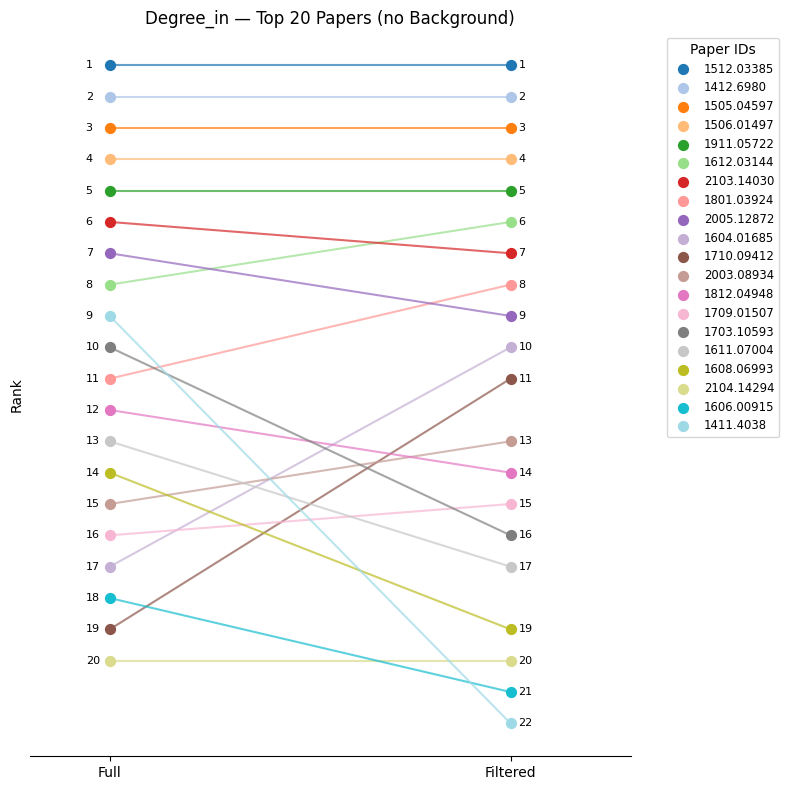

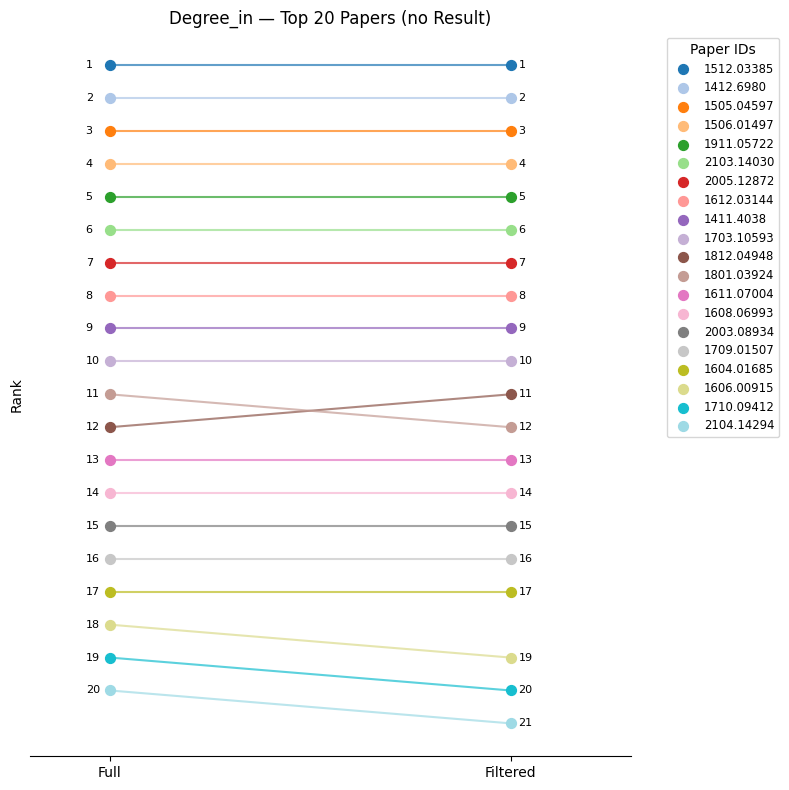

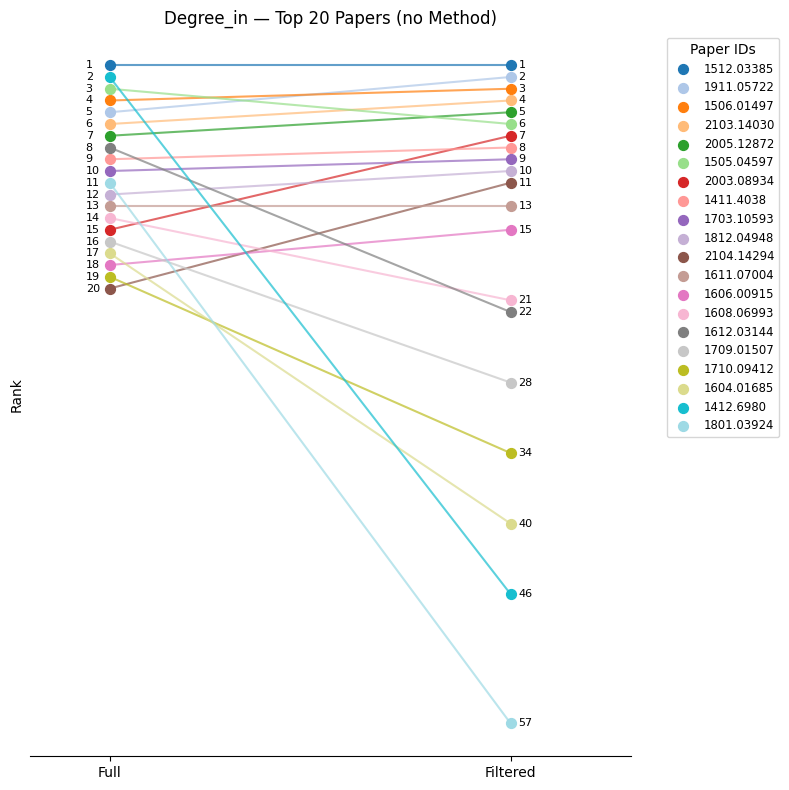

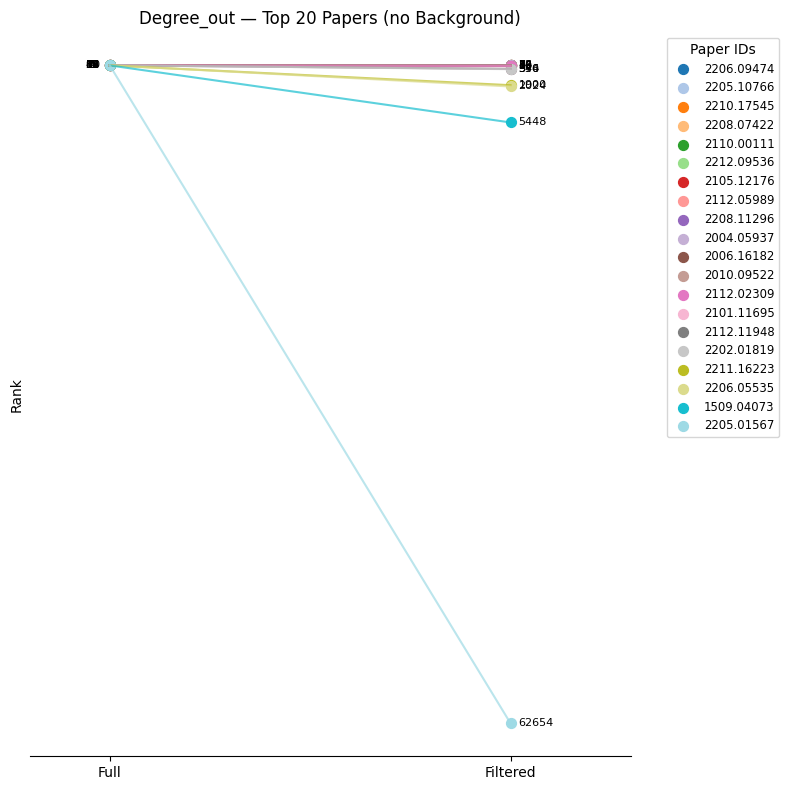

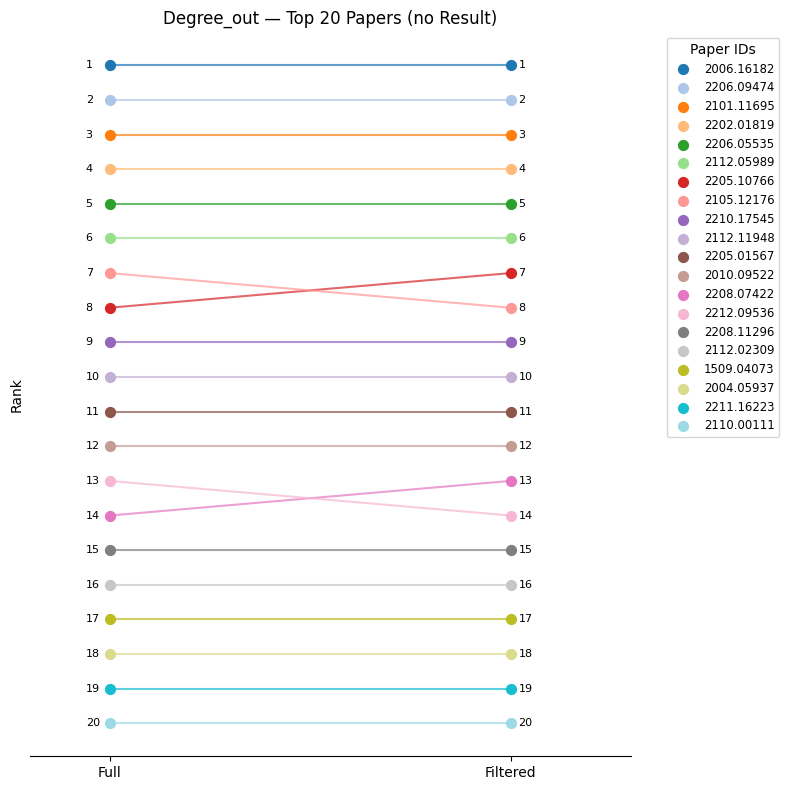

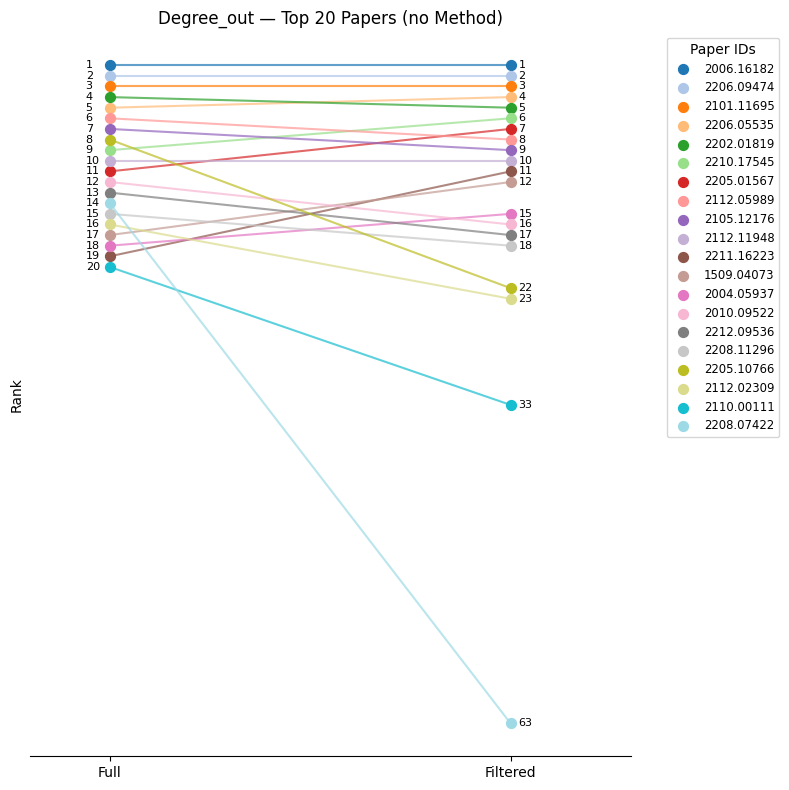

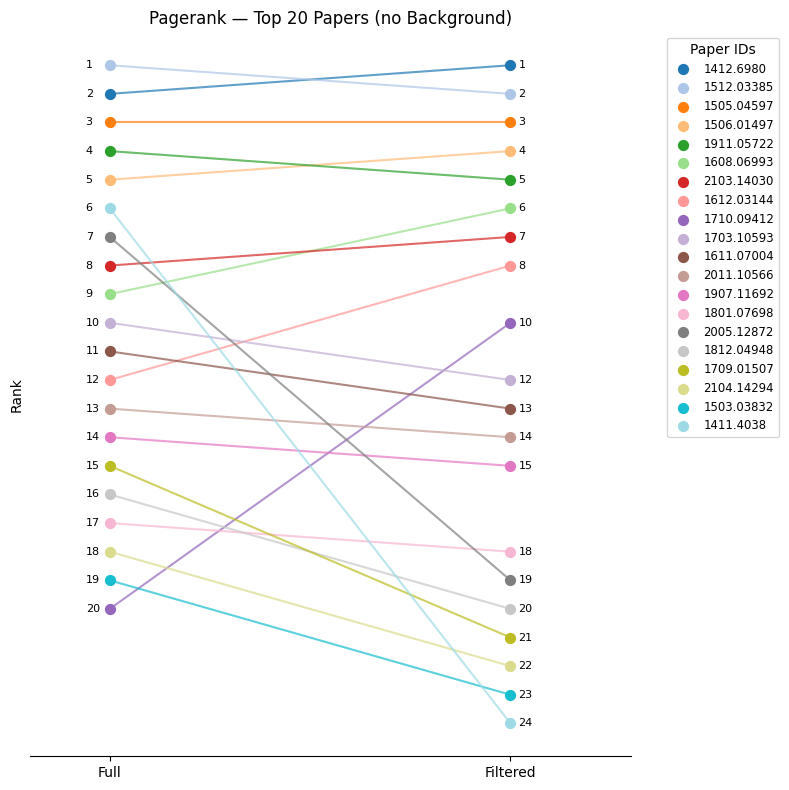

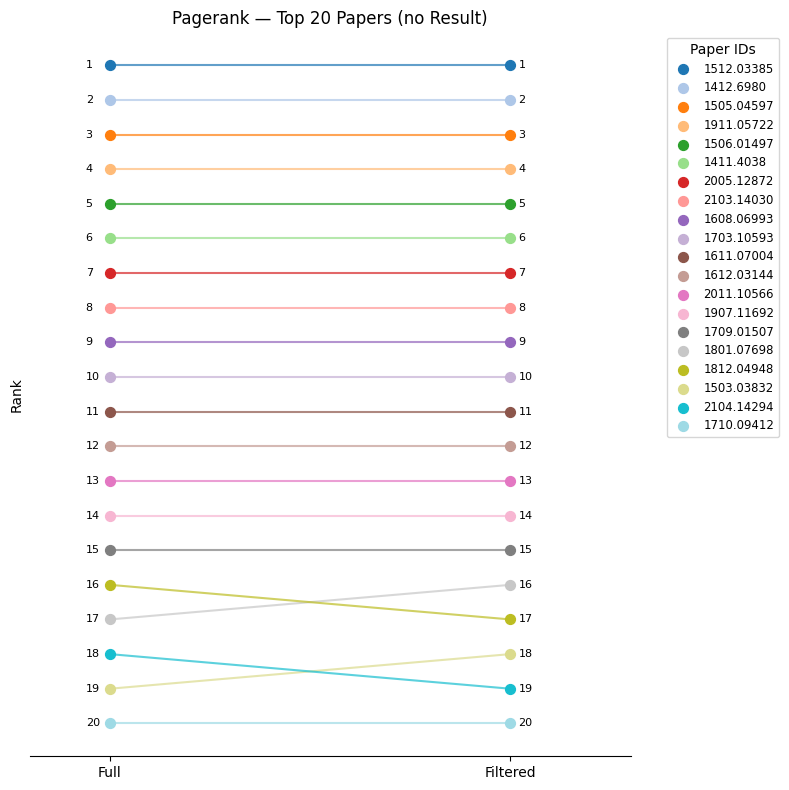

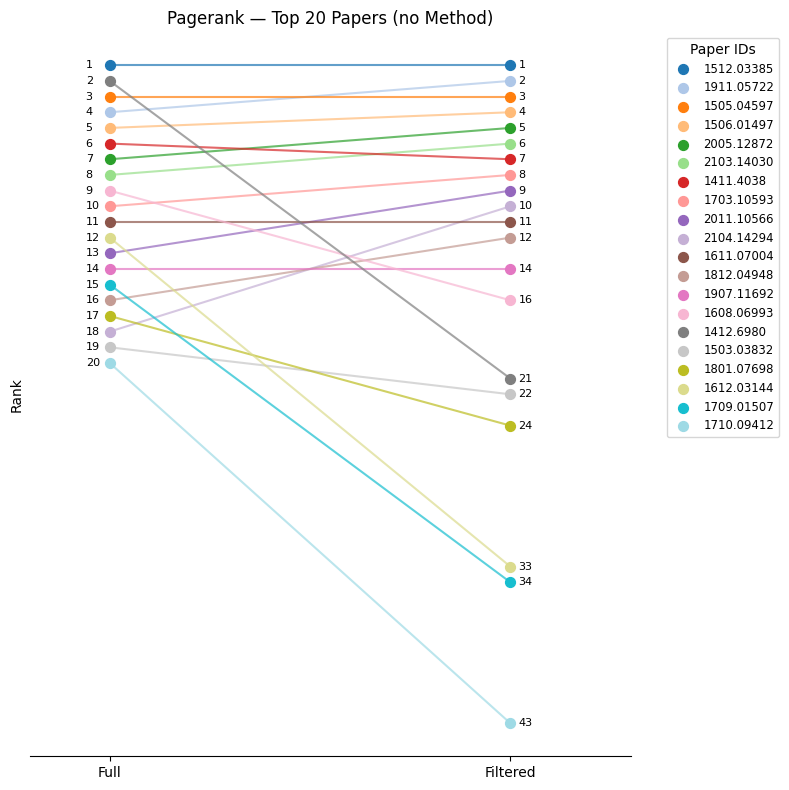

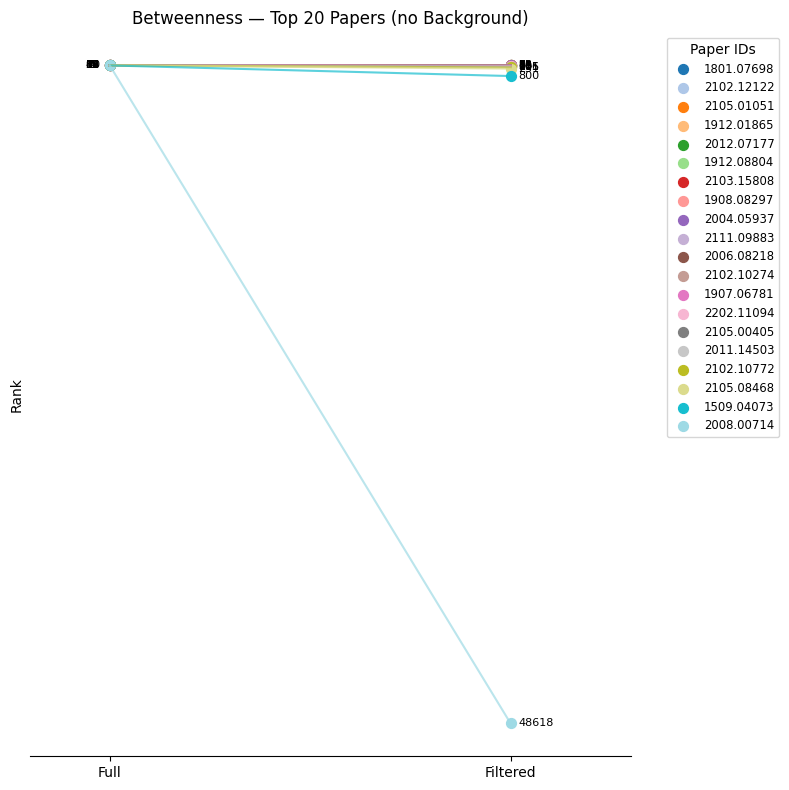

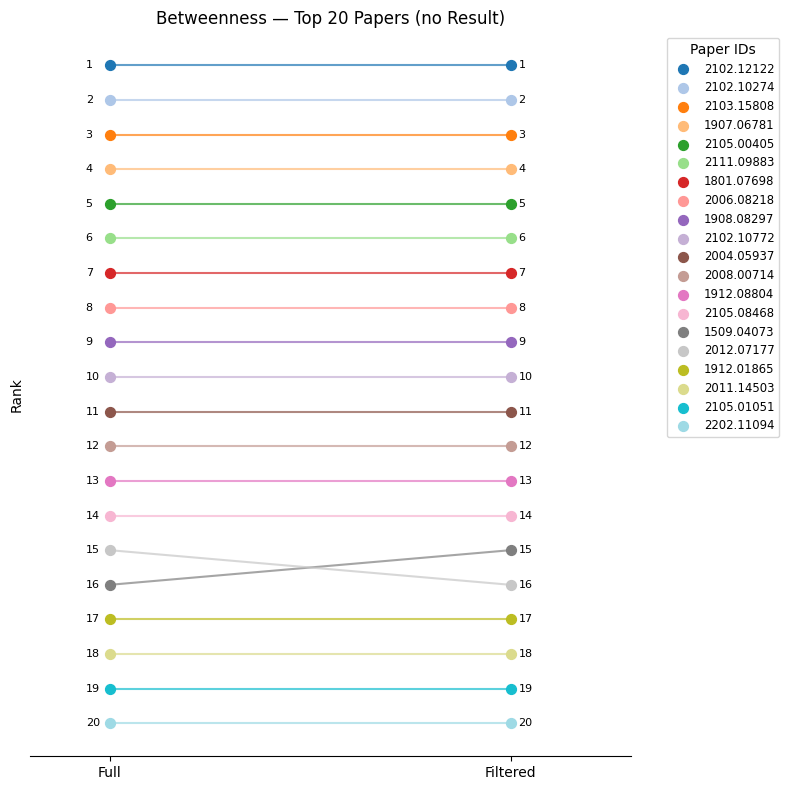

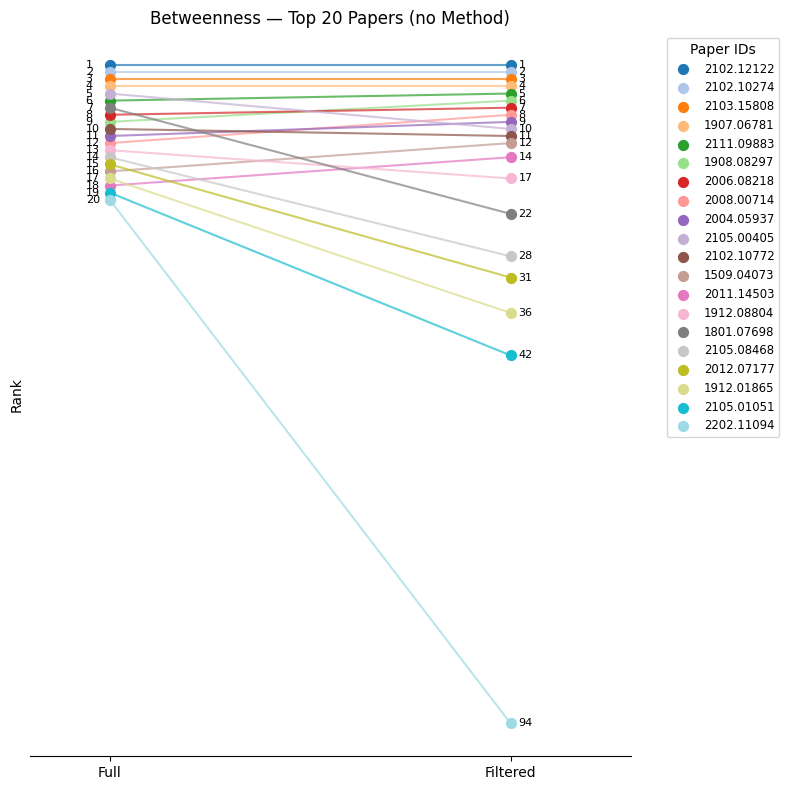

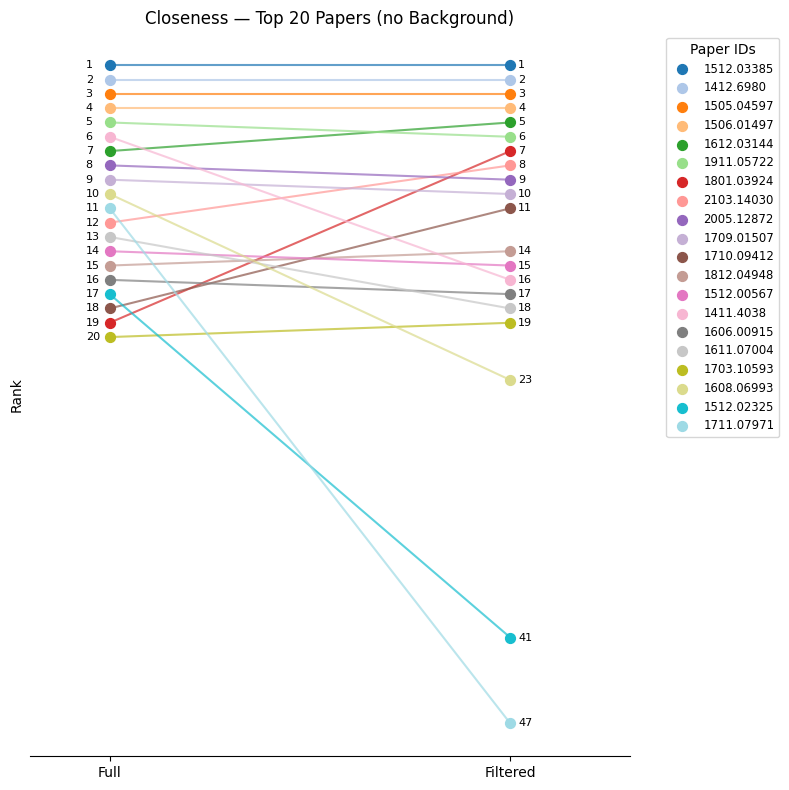

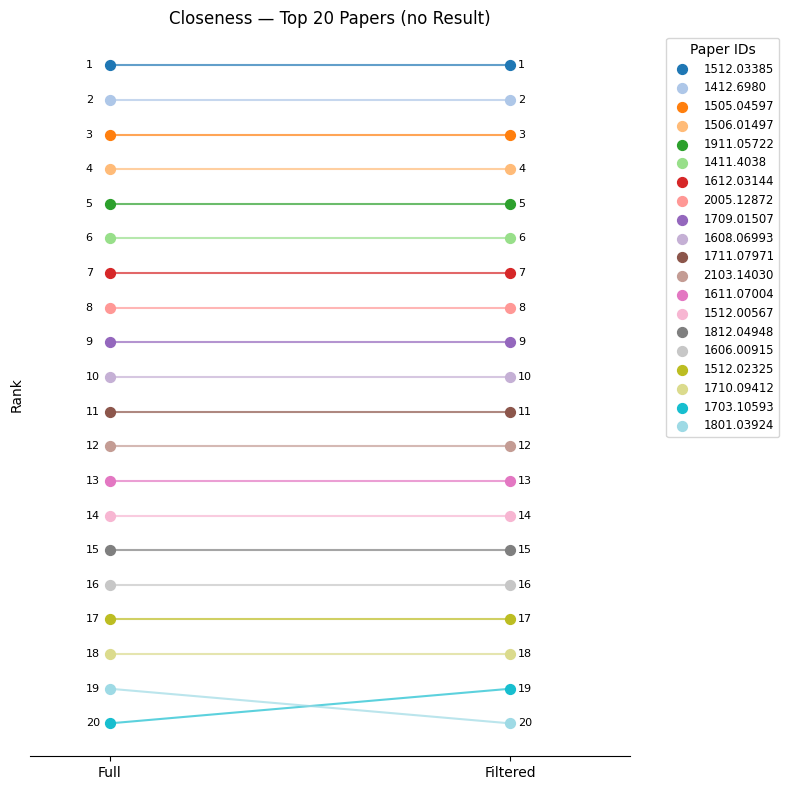

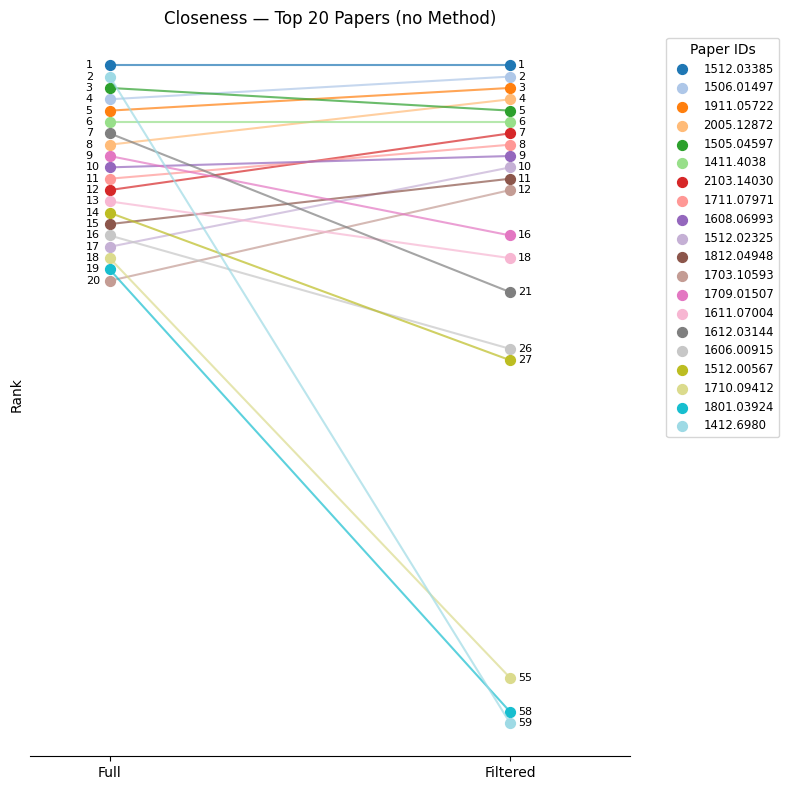

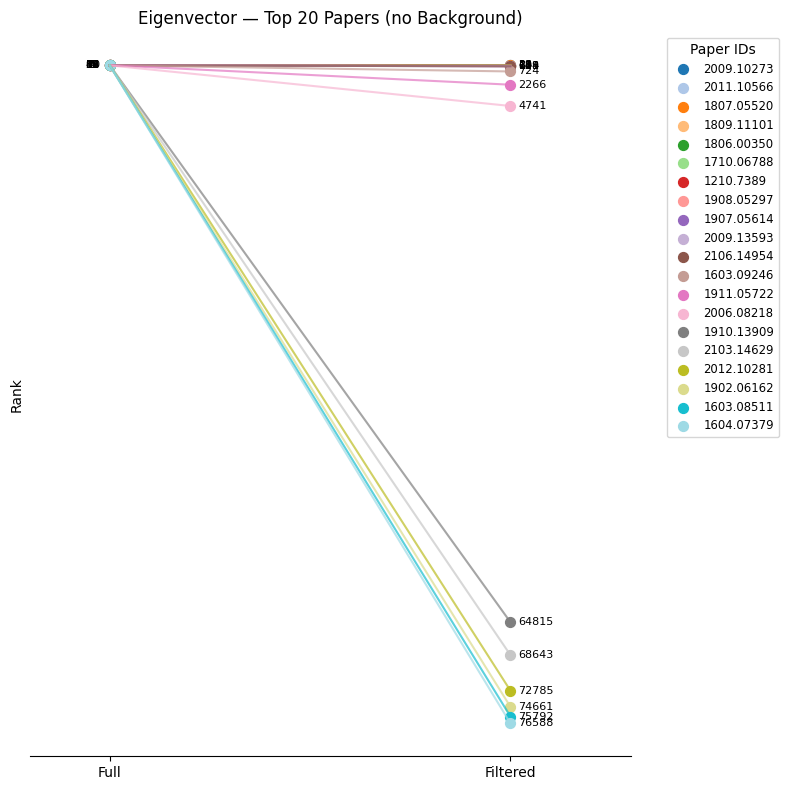

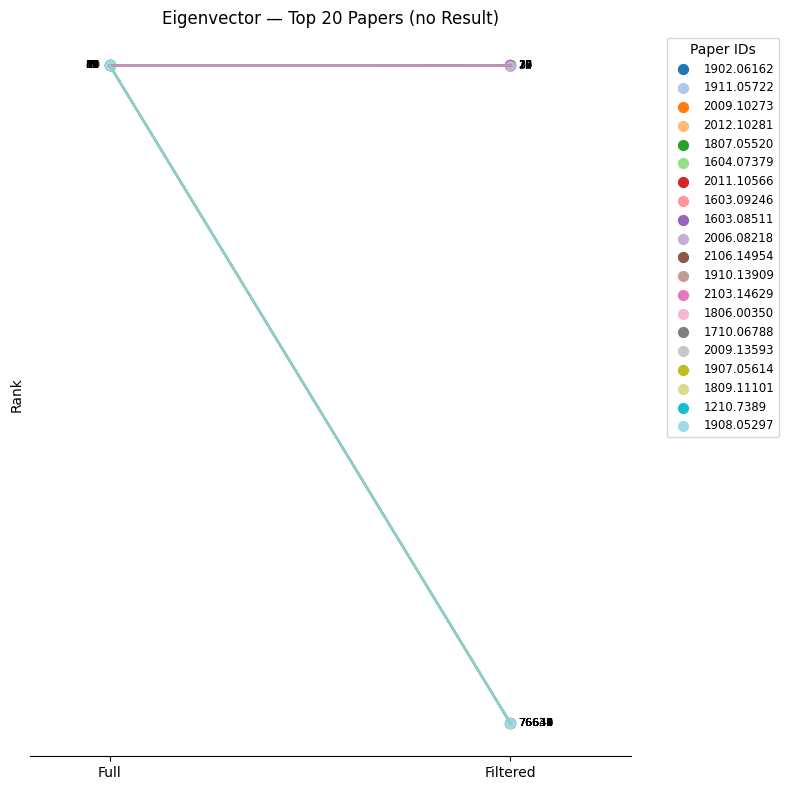

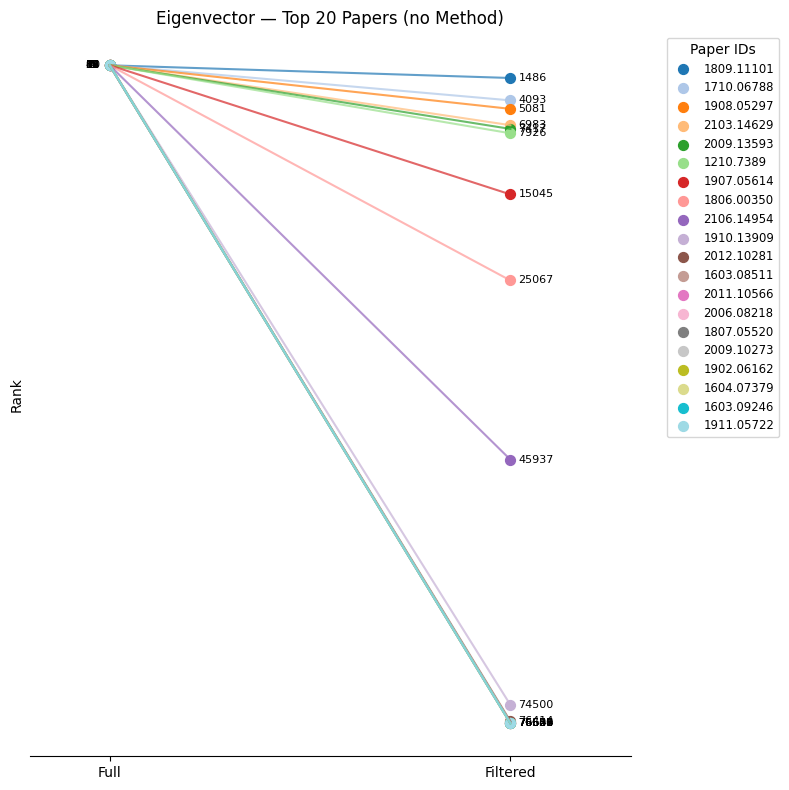

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# cria pasta de saída
output_dir = "centrality_plots"
os.makedirs(output_dir, exist_ok=True)

top_n = 20
intents = {
    "Background": "Background Filtered",
    "Result":     "Result Filtered",
    "Method":     "Method Filtered",
}
all_results = {}

for measure in centralities["Full Network"]:
    full_scores = centralities["Full Network"][measure]

    df_results = {}
    for intent_name, filt_key in intents.items():
        filt_scores = centralities[filt_key][measure]
        
        # Build DataFrame of scores
        df_plot = pd.DataFrame({
            "paper":               list(full_scores.keys()),
            f"{measure}_full":     list(full_scores.values()),
            f"{measure}_filtered": [filt_scores.get(p, 0) for p in full_scores],
            "score_full":     list(full_scores.values()),
            "score_filtered": [filt_scores.get(p, 0) for p in full_scores]
        })
        
        # --- explicit ranking for "full" ---
        full_order = df_plot[f"{measure}_full"].sort_values(ascending=False).index
        ranks_full = pd.Series(range(1, len(df_plot) + 1), index=full_order)
        df_plot["rank_full"] = df_plot.index.map(ranks_full)
        
        # --- explicit ranking for "filtered" ---
        filt_order = df_plot[f"{measure}_filtered"].sort_values(ascending=False).index
        ranks_filt = pd.Series(range(1, len(df_plot) + 1), index=filt_order)
        df_plot["rank_filtered"] = df_plot.index.map(ranks_filt)
        
        # Select and sort the top_n papers by full-network rank
        top_papers = df_plot.nsmallest(top_n, "rank_full").copy()
        top_papers.sort_values("rank_filtered", inplace=True)  # for consistent jitter ordering
        df_results[intent_name] = top_papers.sort_values(by=['rank_full'])
        
        # Compute horizontal jitter for any shared filtered-ranks
        y_vals = top_papers["rank_filtered"].values
        groups = {}
        for idx, y in enumerate(y_vals):
            groups.setdefault(y, []).append(idx)
        jitter_width = 0.15
        x_offsets = np.zeros(len(y_vals))
        for y, idxs in groups.items():
            offsets = np.linspace(-jitter_width, jitter_width, len(idxs)) if len(idxs) > 1 else [0]
            for off, i in zip(offsets, idxs):
                x_offsets[i] = off
        
        # Plot usando fig/ax para poder salvar
        fig, ax = plt.subplots(figsize=(8, max(6, top_n * 0.4)))
        x_full, x_filt = 0, 1
        cmap = plt.get_cmap("tab20", top_n)
        
        for i, row in enumerate(top_papers.itertuples()):
            color = cmap(i)
            ax.plot(
                [x_full, x_filt + x_offsets[i]],
                [row.rank_full, row.rank_filtered],
                color=color, alpha=0.7
            )
            ax.scatter(
                x_full, 
                row.rank_full,     
                color=color, 
                s=50)
            ax.text(
                x_full - 0.06,
                row.rank_full,
                int(row.rank_full),
                va="center",
                ha="left",
                fontsize=8
            )
            ax.scatter(
                x_filt + x_offsets[i],
                row.rank_filtered,
                color=color,
                s=50,
                label=row.paper
            )
            ax.text(
                x_filt + x_offsets[i] + 0.02,
                row.rank_filtered,
                int(row.rank_filtered),
                va="center",
                ha="left",
                fontsize=8
            )
        ax.get_yaxis().set_ticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        # finalize axes & legend
        ax.set_xticks([x_full, x_filt])
        ax.set_xticklabels(["Full", "Filtered"])
        ax.set_xlim(-0.2, 1.3)
        ax.invert_yaxis()
        ax.set_ylabel("Rank")
        ax.set_title(f"{measure.capitalize()} — Top {top_n} Papers (no {intent_name})")
        ax.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            fontsize="small",
            title="Paper IDs"
        )
        
        plt.tight_layout()
        
        # salva como PDF
        # filename = f"{measure.lower()}_no_{intent_name.replace(' ', '_').lower()}.pdf"
        # fig.savefig(os.path.join(output_dir, filename), format='pdf')
        plt.show()
        plt.close(fig)
    all_results[measure] = df_results

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# cria pasta de saída
output_dir = "centrality_plots"
os.makedirs(output_dir, exist_ok=True)

top_n = 20
# mapeia nome amigável -> chave no seu dicionário centralities
intents = {
    "Background": "Background Filtered",
    "Result":     "Result Filtered",
    "Method":     "Method Filtered",
}

for measure, full_scores in centralities["Full Network"].items():
    # transforma dict em DataFrame
    df = pd.DataFrame({
        "paper": list(full_scores.keys()),
        "score_full":     list(full_scores.values()),
    })
    # para cada filtro, plota uma bump chart
    for intent_name, filt_key in intents.items():
        filt_scores = centralities[filt_key][measure]
        df["score_filtered"] = df["paper"].map(filt_scores).fillna(0)
        
        # --- rankeia explicitamente full e filtered ---
        df["rank_full"] = df["score_full"].rank(ascending=False, method="first").astype(int)
        df["rank_filtered"] = df["score_filtered"].rank(ascending=False, method="first").astype(int)
        
        # seleciona apenas os top_n de cada e faz união
        top_full = set(df.nsmallest(top_n, "rank_full")["paper"])
        top_filt = set(df.nsmallest(top_n, "rank_filtered")["paper"])
        subset = df[df["paper"].isin(top_full.union(top_filt))].copy()
        
        # clipe ranks p/ valores > top_n e cria labels
        subset["rank_filt_clip"] = subset["rank_filtered"].apply(lambda r: r if r <= top_n else top_n + 1)
        subset["filtered_label"] = subset["rank_filtered"].apply(lambda r: f"{r}" if r <= top_n else "…")
        
        # monta o bump plot
        fig, ax = plt.subplots(figsize=(6, max(4, len(subset)*0.2)))
        for _, row in subset.iterrows():
            ax.plot(
                [0, 1],
                [row["rank_full"], row["rank_filt_clip"]],
                marker="o",
                linewidth=2,
                label=None
            )
            # anota rank à esquerda
            ax.text(
                -0.05, row["rank_full"],
                str(row["rank_full"]),
                ha="right", va="center", fontsize=8
            )
            # anota valor de centralidade à direita
            ax.text(
                1.05, row["rank_filt_clip"],
                f"{row['score_filtered']:.2e}",
                ha="left", va="center", fontsize=8
            )
        
        # configurações de estilo
        ax.set_xlim(-0.2, 1.2)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Full Network", f"{intent_name} Filtered"], fontsize=10)
        ax.invert_yaxis()                      # rank 1 no topo
        ax.set_ylabel("Rank")
        ax.set_title(f"Bump Chart – {measure} ({intent_name})", pad=20)
        # somente remova se existir
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
    
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        
        # salva figura
        fn = f"{measure.replace('/', '_')}_{intent_name}.png"
        fig.savefig(os.path.join(output_dir, fn), dpi=300, bbox_inches="tight")
        plt.close(fig)

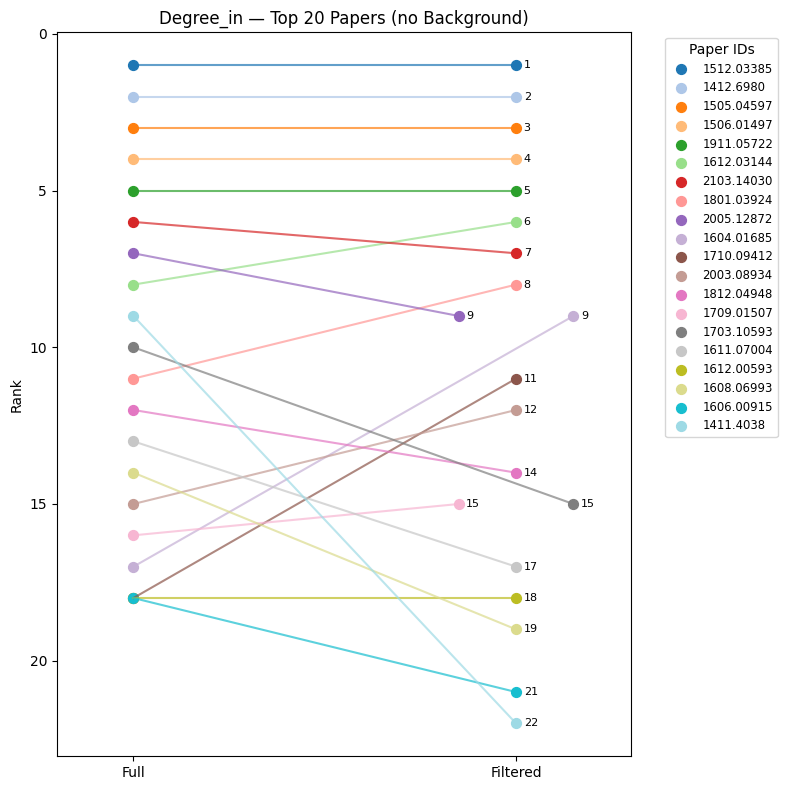

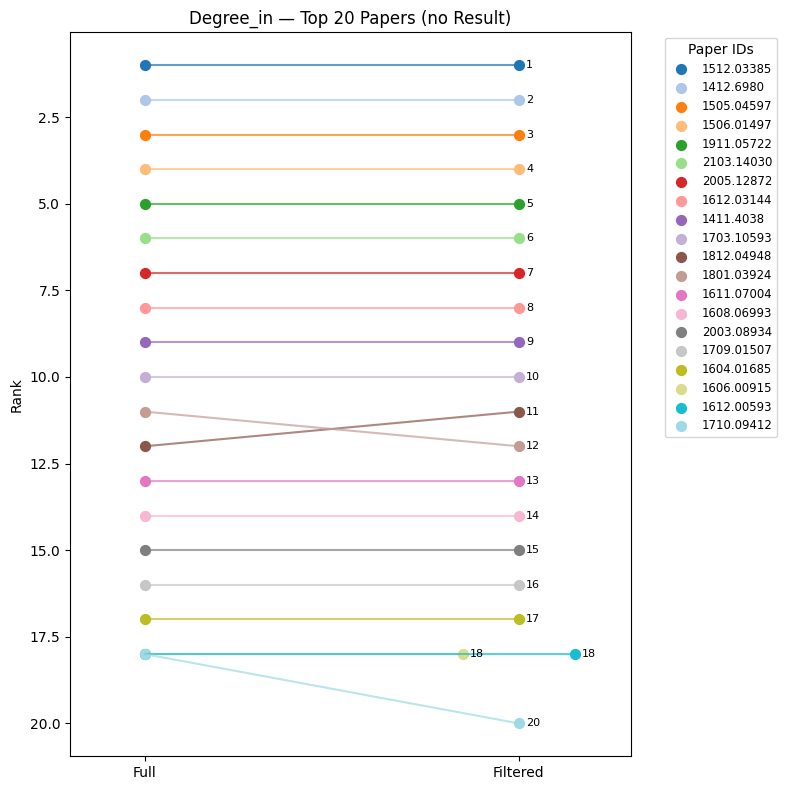

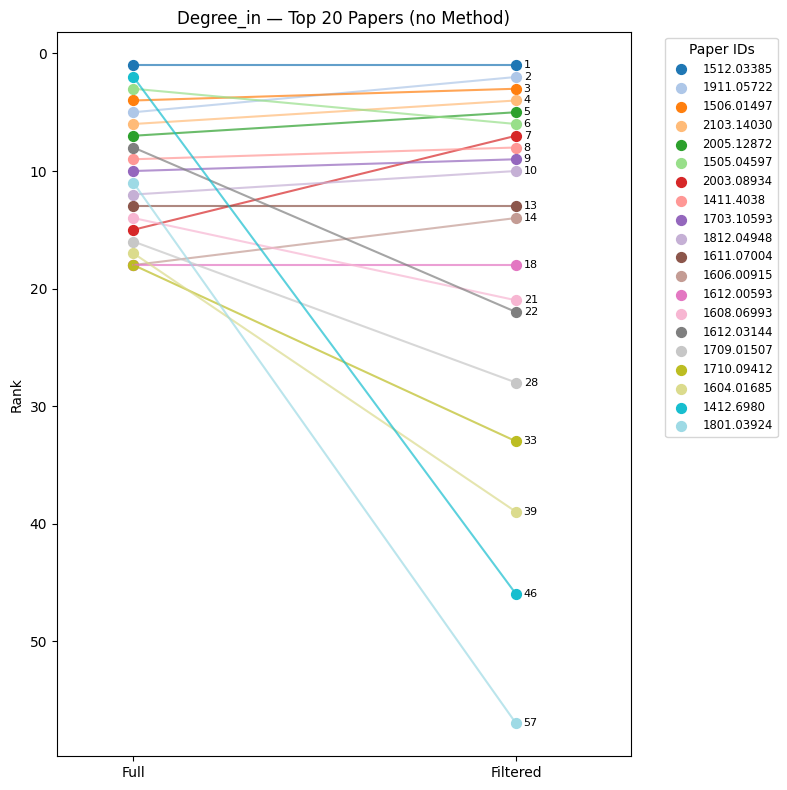

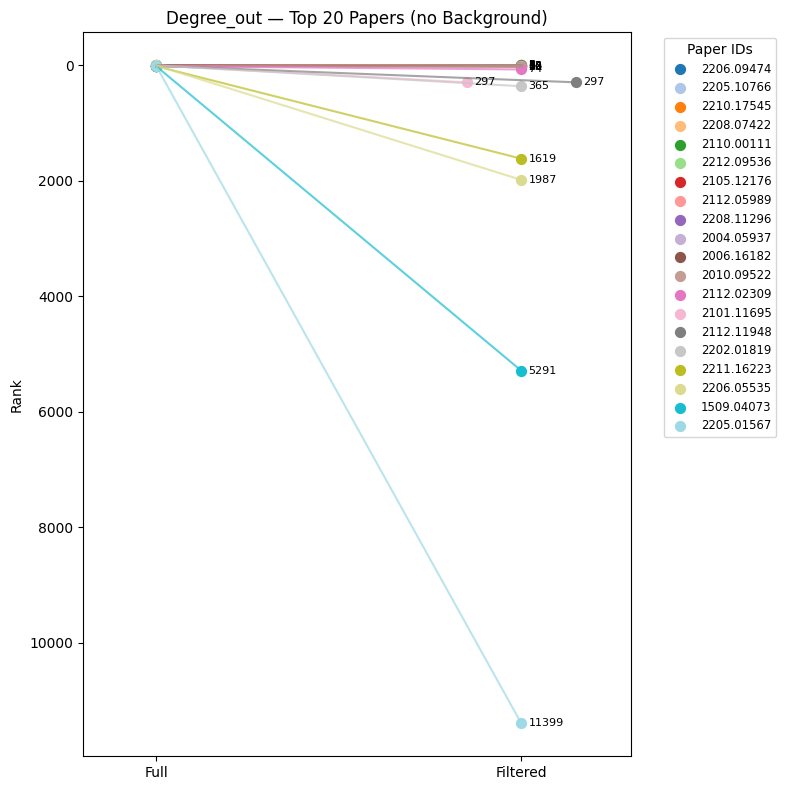

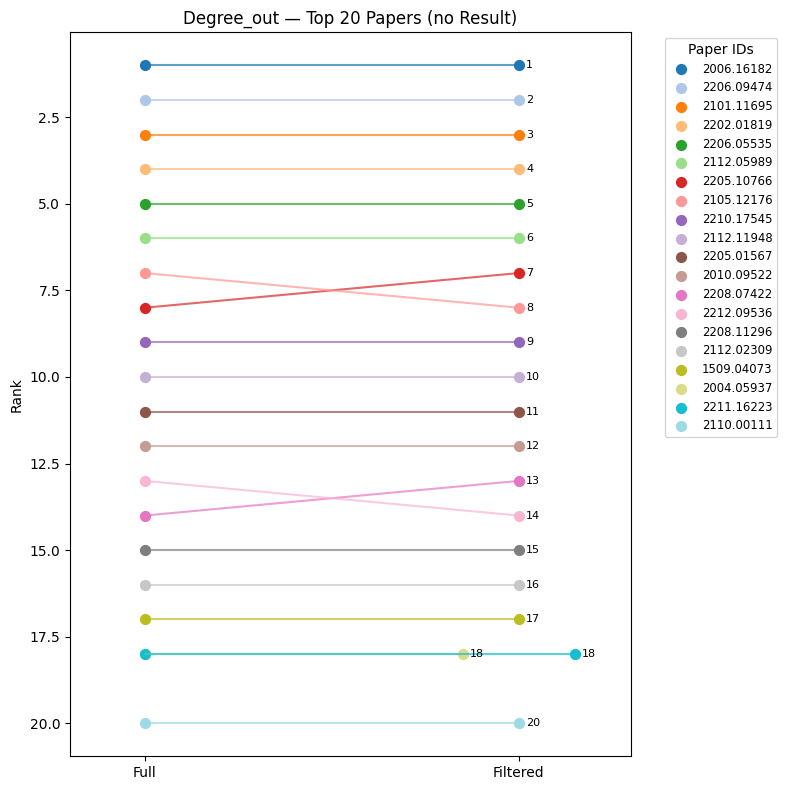

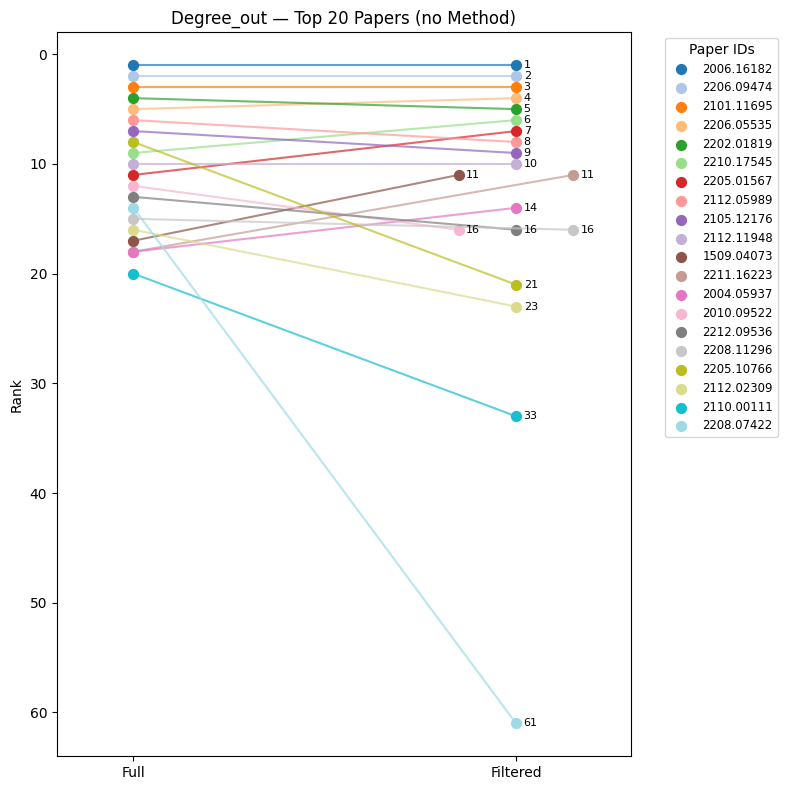

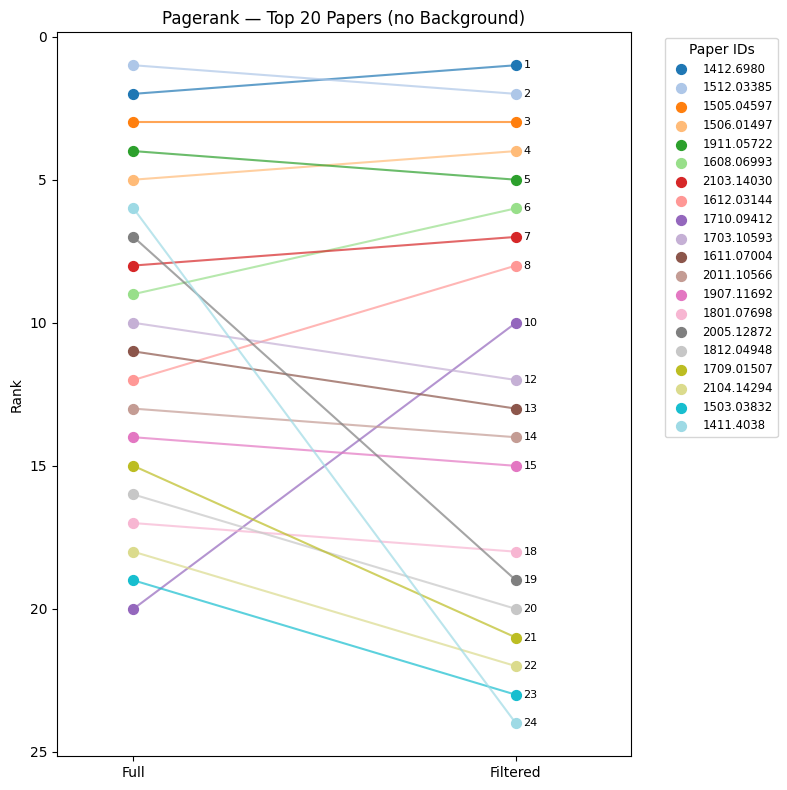

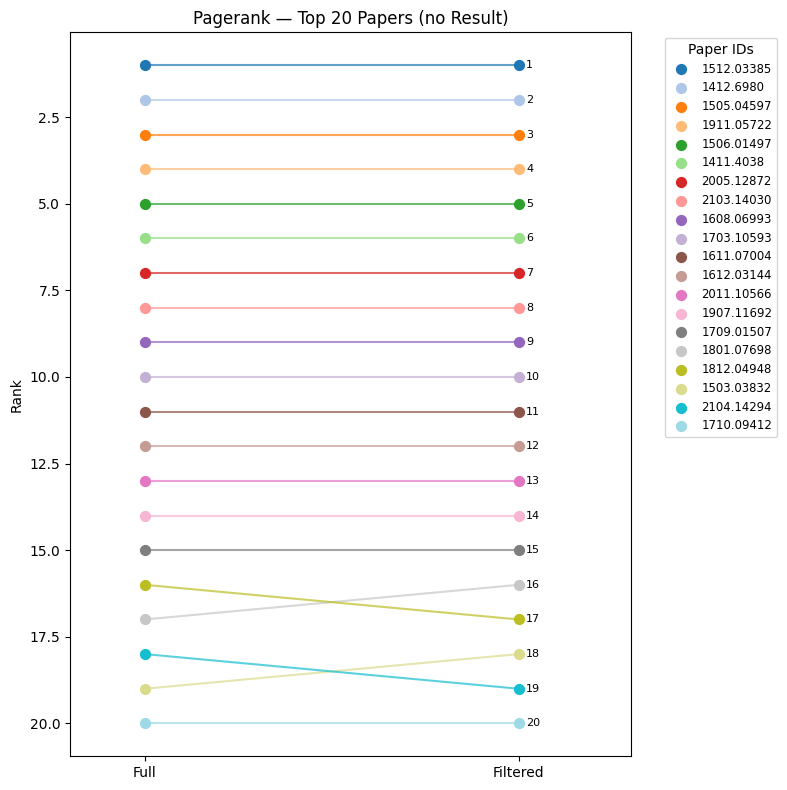

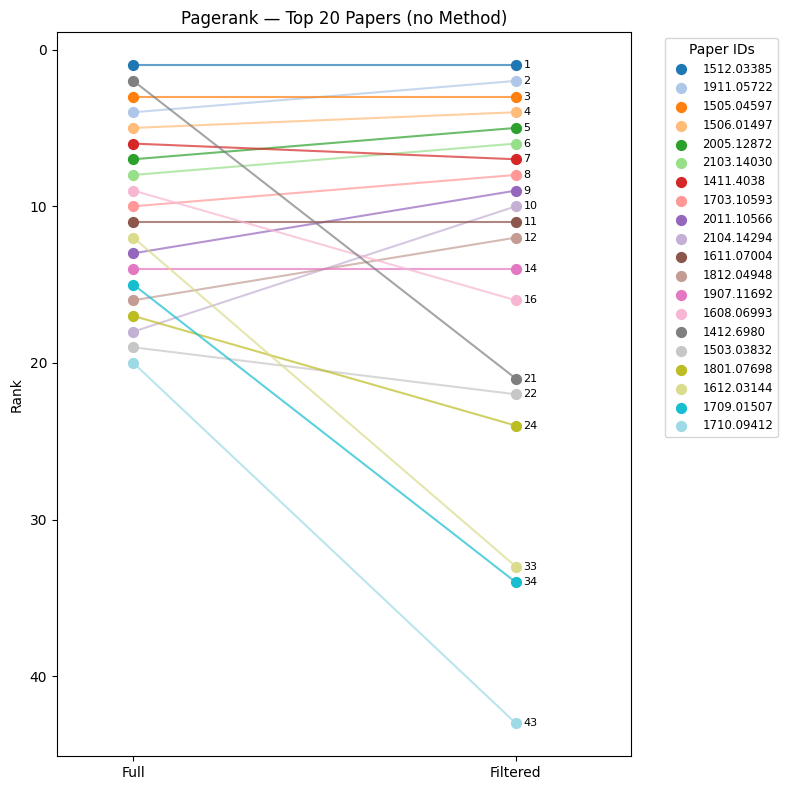

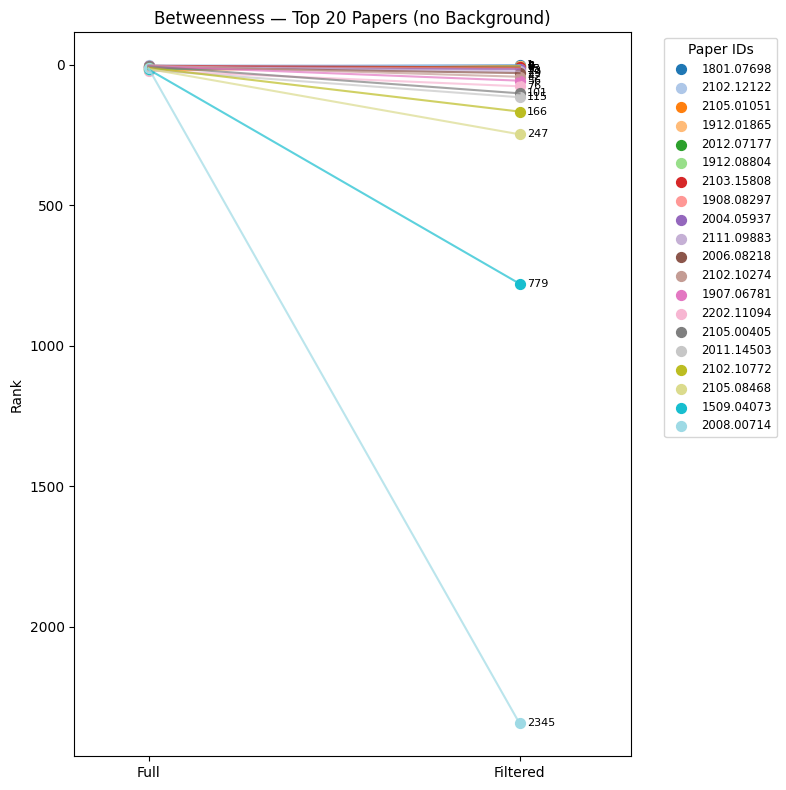

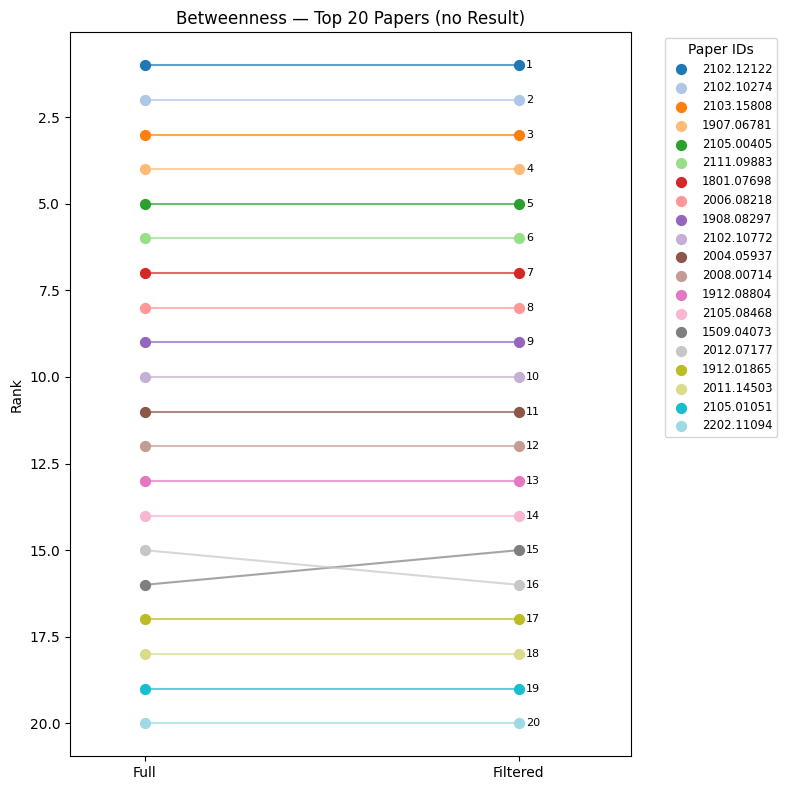

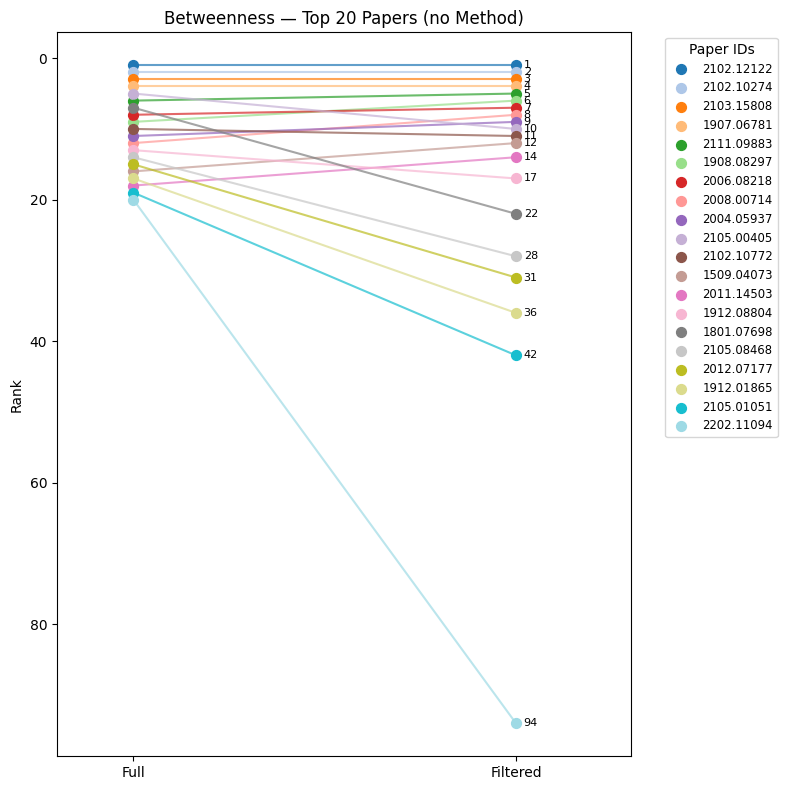

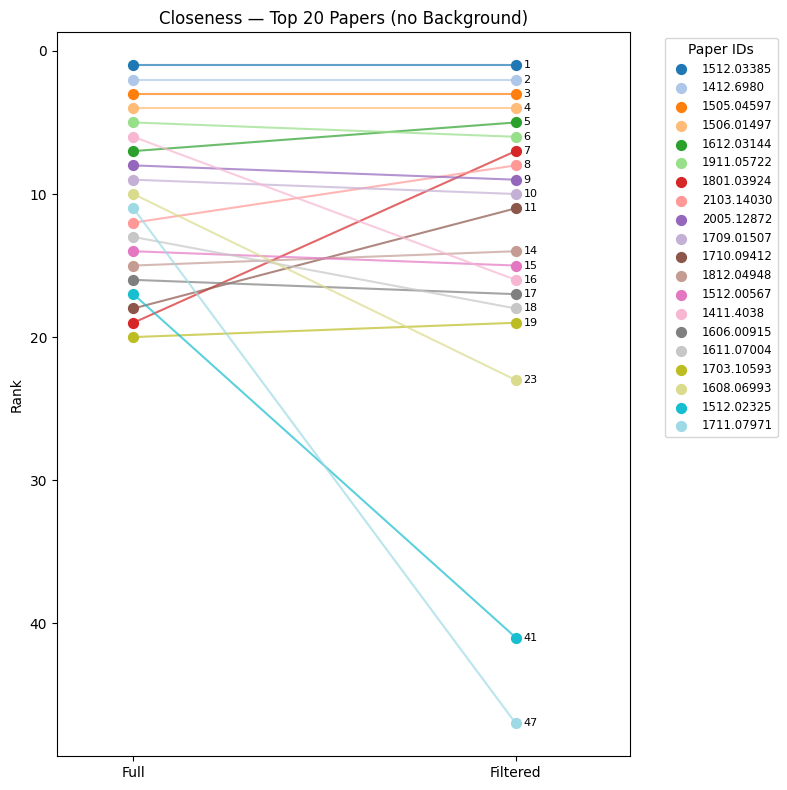

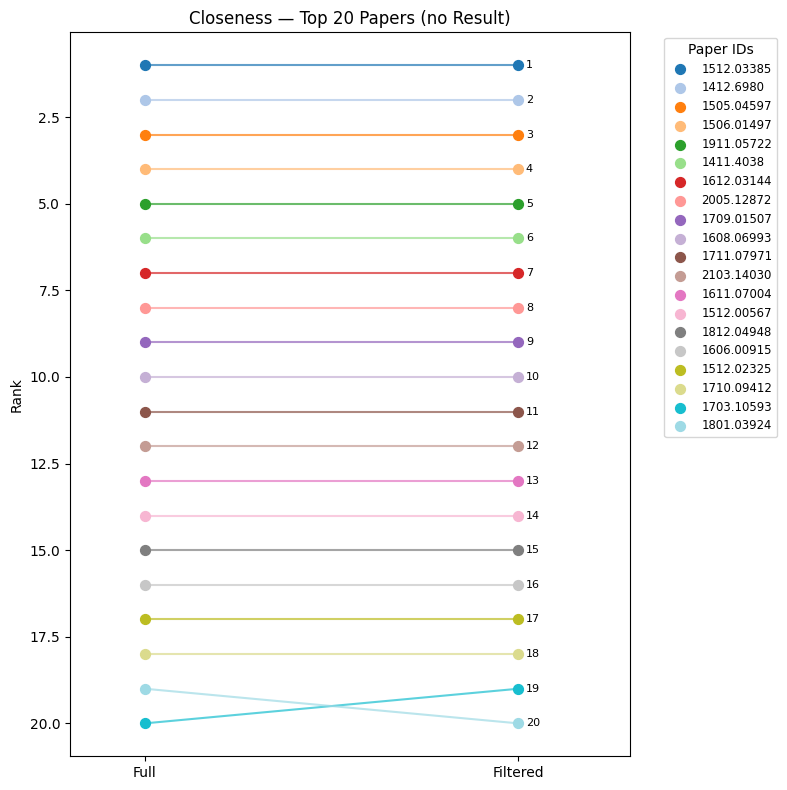

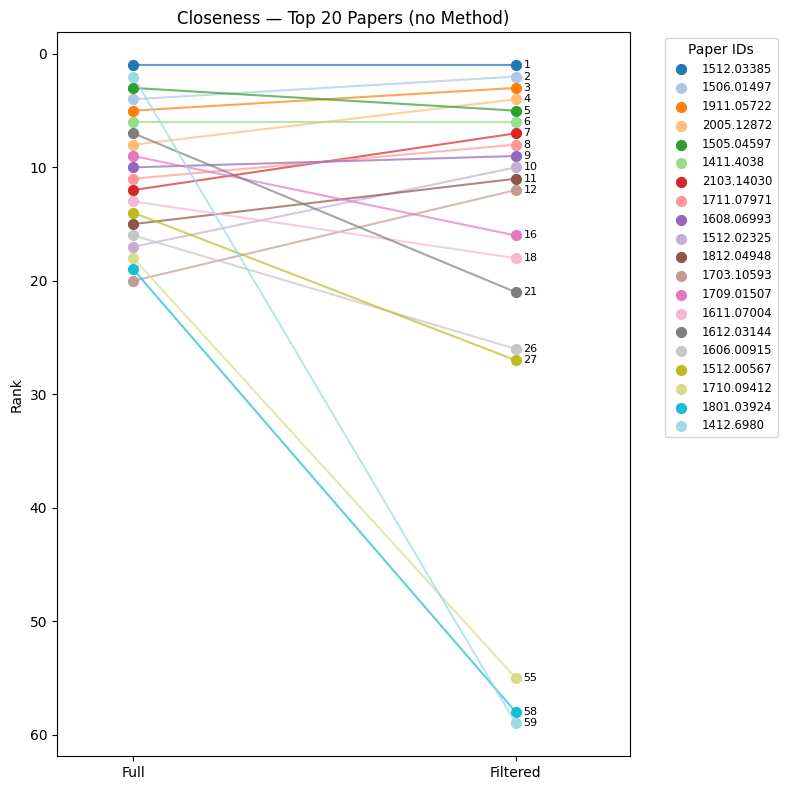

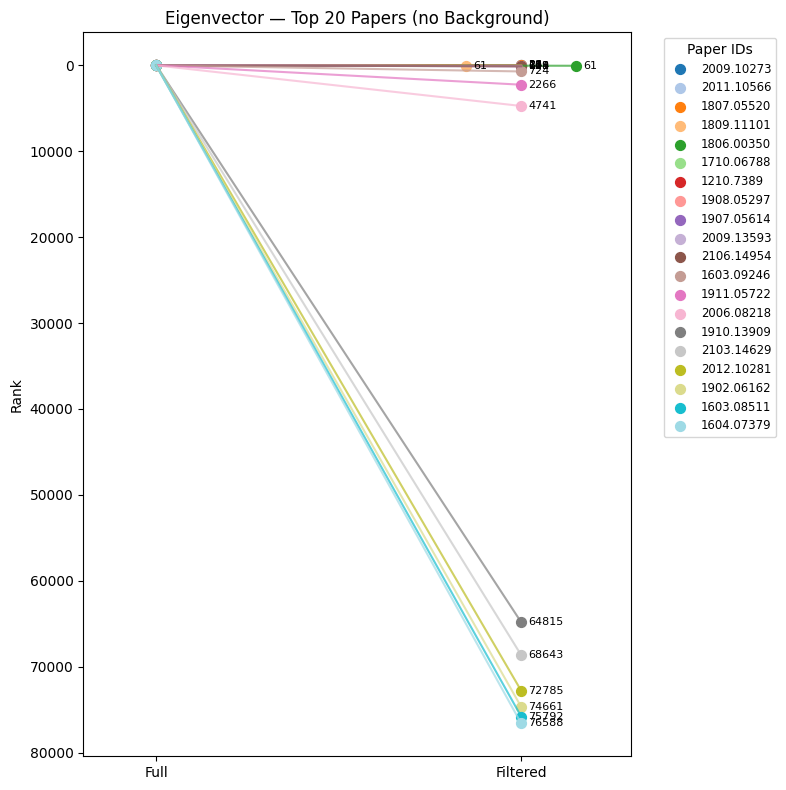

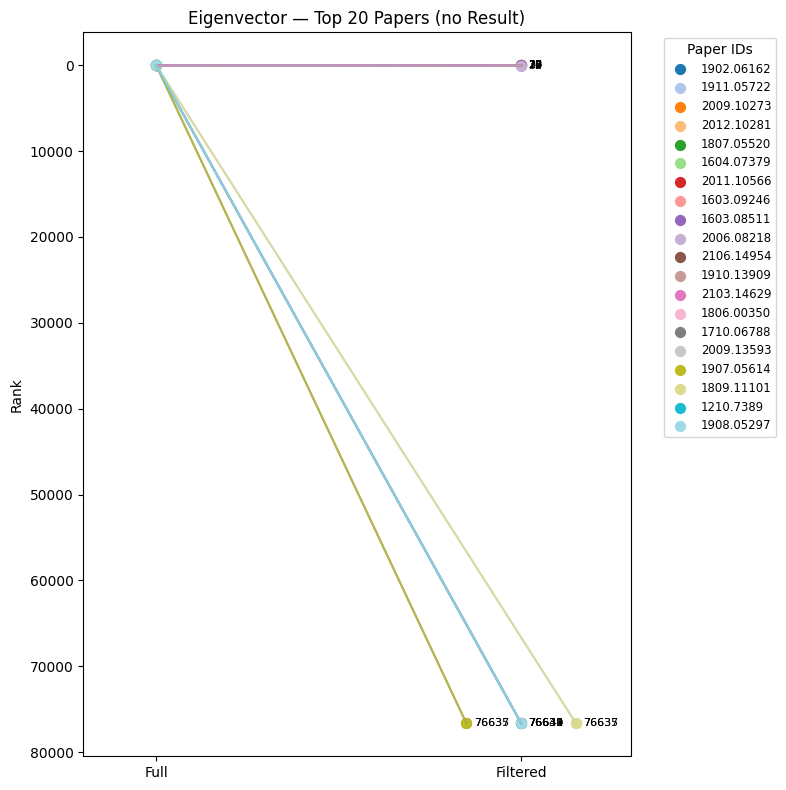

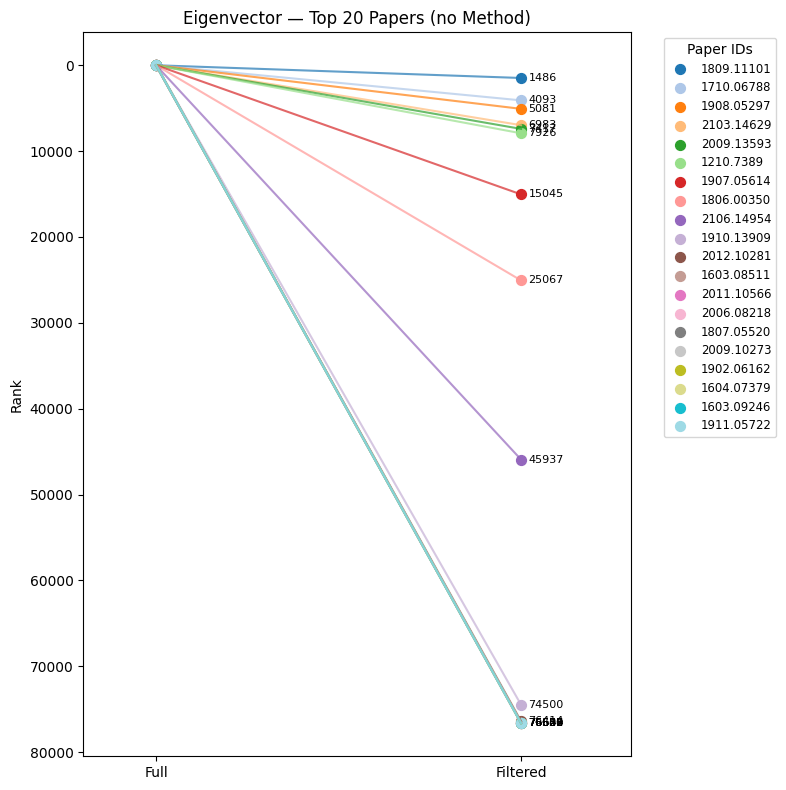

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

top_n = 20
intents = {
    "Background": "Background Filtered",
    "Result":     "Result Filtered",
    "Method":     "Method Filtered",
}

for measure in centralities["Full Network"]:
    full_scores = centralities["Full Network"][measure]
    
    for intent_name, filt_key in intents.items():
        filt_scores = centralities[filt_key][measure]
        
        # Build DataFrame of scores + ranks
        df_plot = pd.DataFrame({
            "paper":               list(full_scores.keys()),
            f"{measure}_full":       list(full_scores.values()),
            f"{measure}_filtered":   [filt_scores.get(p, 0) for p in full_scores]
        })
        df_plot["rank_full"]     = df_plot[f"{measure}_full"].rank(ascending=False, method="min")
        df_plot["rank_filtered"] = df_plot[f"{measure}_filtered"].rank(ascending=False, method="min")
        
        # Select and sort the top_n papers by full-network rank
        top_papers = df_plot.nsmallest(top_n, "rank_full").copy()
        top_papers.sort_values("rank_filtered", inplace=True)  # for consistent jitter ordering
        
        # Compute horizontal jitter for any shared filtered-ranks
        y_vals = top_papers["rank_filtered"].values
        groups = {}
        for idx, y in enumerate(y_vals):
            groups.setdefault(y, []).append(idx)
        jitter_width = 0.15
        x_offsets = np.zeros(len(y_vals))
        for y, idxs in groups.items():
            n = len(idxs)
            offsets = np.linspace(-jitter_width, jitter_width, n) if n > 1 else [0]
            for off, i in zip(offsets, idxs):
                x_offsets[i] = off
        
        # Plot
        plt.figure(figsize=(8, max(6, top_n * 0.4)))
        x_full, x_filt = 0, 1
        cmap = plt.get_cmap("tab20", top_n)
        
        for i, row in enumerate(top_papers.itertuples()):
            color = cmap(i)
            # line
            plt.plot(
                [x_full, x_filt + x_offsets[i]],
                [row.rank_full, row.rank_filtered],
                color=color, alpha=0.7
            )
            # markers
            plt.scatter(x_full, row.rank_full,     color=color, s=50)
            plt.scatter(
                x_filt + x_offsets[i],
                row.rank_filtered,
                color=color,
                s=50,
                label=row.paper
            )
            # numeric rank label at filtered end
            plt.text(
                x_filt + x_offsets[i] + 0.02,
                row.rank_filtered,
                int(row.rank_filtered),
                va="center",
                ha="left",
                fontsize=8
            )
        
        # finalize axes & legend
        plt.xticks([x_full, x_filt], ["Full", "Filtered"])
        plt.xlim(-0.2, 1.3)
        plt.gca().invert_yaxis()
        plt.ylabel("Rank")
        plt.title(f"{measure.capitalize()} — Top {top_n} Papers (no {intent_name})")
        plt.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            fontsize="small",
            title="Paper IDs"
        )
        plt.tight_layout()
        plt.show()


In [12]:
df.shape

(303372, 8)

In [13]:
GG = nx.from_pandas_edgelist(df, 
                             source="id",
                             target="cited_ids", 
                             # edge_attr="label", 
                             #edge_key="",
                             create_using=nx.DiGraph())

In [15]:
print(GG)

DiGraph with 76640 nodes and 171403 edges


In [16]:
labels = [] 
for i in unarxiv_info['discipline'].values:
    labels.append({"label": i})

In [17]:
id_to_label = pd.Series(labels, index=unarxiv_info['id']).to_dict()
nx.set_node_attributes(GG, id_to_label)

In [18]:
# g = ig.Graph.from_networkx(GG)
# xn.save(g,"unarxiv_all.xnet")

In [19]:
GG_cc = max(nx.weakly_connected_components(GG), key=len)
GG = GG.subgraph(GG_cc)

In [20]:
print(GG)

DiGraph with 71939 nodes and 165615 edges


In [84]:
# def save_graph_paper(GG, paper):
#     G = nx.DiGraph()
#     G.add_edges_from(GG.in_edges(paper))
#     g = ig.Graph.from_networkx(G)
#     xn.save(g, f"{paper}_graph.xnet")

In [85]:
# save_graph_paper(GG, "1512.03385")

In [1]:
# plot_by_paper(GG,"1512.03385")

In [19]:
# g = ig.Graph.from_networkx(GG)
# xn.save(g,"unarxiv_weakly_connected.xnet")